# Mapping Swiss Ecosystems from Aerial Images and Environmental Variables

This notebook presents the analyses and data pipeline for the project.  
It demonstrates that this pipeline is fully reproducible and provides a systematic workflow for mapping ecosystems in Switzerland using both aerial imagery and environmental variables.

---

<p style="display:flex; justify-content: space-between; font-size: 0.9em;">
<span>Loïc Trochen, Dany Montandon — SIE Section, Image Processing for Earth Observation</span>
<span>Nov/Dec 25 – Jan 26</span>
</p>

---

## 📂 Project Folder Structure

**Root project folder:** `project/`

- `data/`
  - `images.zip/`            ← Aerial images, named by ID (e.g., 2572824_1174283.tif)
  - `images/`            ← Aerial images, named by ID (e.g., 2572824_1174283.tif)
  - `images_png/`            ← Aerial images, named by ID (e.g., 2572824_1174283.png)  
  - `dataset_split.csv`  ← Tabular data with IDs, split, SWECO variables, EUNIS labels
- `figures/`                 ← Save different plots
- `models/`                   ← Save the best model for different architecture and parameters
- `utils/`  
  - `eunis_labels.py`                  ← Mapping from numeric ID to EUNIS label  
  - `sweco_group_of_variables.py`      ← SWECO variable thematic groups
  - `scripts.py`                       ← Python scripts with utils functions
- `ipeo_project.ipynb` ← Notebook: pipeline, results, plots
- `inference.ipynb` ← Notebook: test the best model on a few samples of the test set
- `experiment_log.csv` ← CSV to store performance for different models and hyperparameters
- `README.md` ← Project overview, instructions, dependencies  
- `report.pdf`← Project report 
- `environment.yml` ← Python dependencies 

---

## 🧭 Table of Contents

1. [Header & Setup](#1)

2. [Introduction](#2)  
   2.1 [Context and Motivation](#21)  
   2.2 [Objectives of the Project](#22)

3. [Data Loading & Description](#3)  
   3.1 [Overview of the Dataset](#31)  
   3.2 [Data loading](#32)  
   3.3 [Check & Clean SWECO Variables](#33)  
   3.4 [Train / Validation / Test Split](#34)  
   3.5 [Ecosystem Labels (EUNIS)](#35)  
   3.6 [Environmental Variables (SWECO25)](#36)  
   3.7 [Aerial Images Overview](#37)

4. [Data Preprocessing](#4)  
   4.1 [Image Preprocessing](#41)  
   4.2 [Tabular Data Preprocessing](#42)

5. [Methodology](#5)  
   5.1 [Problem Formulation](#51)  
   5.2 [Image-Based Model](#52)  
   5.3 [Tabular-Only Model](#53)  
   5.4 [Multimodal Model (Images + Environmental Variables)](#54)  
   5.5 [Loss Function and Optimization](#55)

6. [Experimental Design](#6)  
   6.1 [Compared Models](#61)  
   6.2 [Ablation Study on Environmental Variables](#62)  
   6.3 [Training Setup and Hyperparameter Selection](#63)

7. [Evaluation Metrics](#7)  
   7.1 [Classification Metrics](#71)  
   7.2 [Computational Performance](#72)

8. [Hyperparameter & Model Exploration](#8)  
   8.1 [Quantitative Results on Training and Validation Set](#81)  
   8.2 [Best Model Choice per Experiment (Hyperparameter Search)](#82)  
   8.3 [Best model choice by architecture (Tabular, Image, Combined)](#83)
   

10. [Quantitative Results on Test Set](#9)  
   9.1 [Test data preparation](#91)  
   9.2 [Quantitative Results on Test Set](#92)  

11. [Visual Analysis](#10)  
    10.1 [Selection of the best model](#101)  
    10.2 [Confusion matrix](#102)  
    10.3 [Spatial Visualization](#103)

12. [Final Remarks](#11)

### One-time preprocessing step (run only once)

The two following cells are used to (1) decompress the image archive and (2) convert the original .tif images into .png format.

This preprocessing step is required only once and should be executed before running the rest of the notebook.
The conversion to PNG significantly reduces image loading overhead during training and evaluation, resulting in faster epochs and more efficient experimentation.

⚠️ To run these steps, the cells must first be uncommented.
Once the images have been extracted and converted, these cells do not need to be run again for subsequent executions of the notebook.

In [1]:
# !unzip -q data/images.zip -d data/images/

In [ ]:
#from pathlib import Path
#from PIL import Image
#import tifffile
#import numpy as np

#img_folder = Path("data/images")
#png_folder = Path("data/images_png")
#png_folder.mkdir(exist_ok=True)

#for tif_path in img_folder.glob("*.tif"):
 #   try:
  
  #      with tifffile.TiffFile(tif_path) as tif:
   #         img_array = tif.asarray()
        
    
    #    if img_array.ndim == 2:
     #       img_array = np.stack([img_array]*3, axis=-1)
      
      #  elif img_array.ndim == 3 and img_array.shape[2] > 3:
       #     img_array = img_array[:, :, :3]
        
       # if img_array.dtype != np.uint8:
        #    img_array = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)

         
       # img = Image.fromarray(img_array)
       # img.save(png_folder / f"{tif_path.stem}.png")

    #except Exception as e:
     #   print(f"Skipping {tif_path}: {e}")

>**Note:** During the conversion process, one image failed to be converted to PNG format due to a file-specific issue. All other images were successfully processed and used in the experiments.


<a id="1"></a>
## 1. Header & Setup

All required dependencies are listed in `environment.yml`

📌 Imports & global setup

In [1]:
# =========================
# Reproducibility settings
# =========================
SEED = 42

import os
import random
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Python & NumPy
random.seed(SEED)
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Global seed set to {SEED}")

Using device: cuda
Global seed set to 42


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Ensure directories exist
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import zipfile
import time
import tifffile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tifffile import imread
from io import BytesIO
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from shapely.geometry import Point
import importlib
import sys
from pathlib import Path

# System path
sys.path.insert(0, os.path.abspath('.'))

# Project utilities
from utils.sweco_group_of_variables import sweco_variables_dict
from utils.scripts import log_experiment, select_best_experiments, plot_experiments, base_model_name

# Display options
plt.style.use("seaborn-v0_8")

print("Setup complete")

Setup complete


<a id="2"></a>
## 2. Introduction

<a id="21"></a>
### 2.1 Context and Motivation

Accurate mapping of ecosystems is essential for biodiversity monitoring, land management, and environmental policy. In Switzerland, ecosystem types are shaped by complex interactions between climate, geology, land use, and human activity. Recent advances in deep learning and remote sensing enable large-scale ecosystem mapping using high-resolution aerial imagery, while ecological raster databases provide complementary environmental information.

This project investigates how aerial imagery and environmental variables contribute to ecosystem classification, and how they can be combined effectively in a multimodal deep learning framework.

---

<a id="22"></a>
### 2.2 Objectives of the Project

The objectives of this project are to:

- Predict EUNIS ecosystem categories (17 classes) across Switzerland
- Compare the predictive performance of:
    - Image-only models
    - Environmental-variable-only models
    - Combined multimodal models
- Perform an ablation study on thematic groups of environmental variables
- Analyse which ecological information is captured by imagery and which is uniquely provided by environmental variables
- Provide an interpretable scientific discussion of the results and their limitations

<a id="3"></a>
## 3. Data Loading & Description

This section loads the dataset, performs initial cleaning, splits the data, and provides visual exploration of the variables and images.

---

<a id="31"></a>
### 3.1 Overview of the Dataset

The dataset contains 16,925 georeferenced locations distributed across Switzerland.  
Each location includes:
- One aerial RGB image (swissIMAGE, 100 × 100 m at 50cm resolution)
- 48 standardized numerical environmental variables (SWECO25)
- One ecosystem label from the EUNIS framework

The data are split geographically to avoid spatial autocorrelation:
- Training set: 60%
- Validation set: 10%
- Test set: 30%

The validation set is used to choose the best model. The final results are computed on the test set.

---

<a id="32"></a>
### 3.2 Tabular Data Loading

In [3]:
# Path to dataset CSV
csv_path = "data/dataset_split.csv"

# Load CSV
df = pd.read_csv(csv_path)
print("Dataset loaded with shape:", df.shape)

# Display column names
columns_list = list(df.columns)
print(columns_list)

# Inspect first few rows
df.head()

Dataset loaded with shape: (16925, 58)
['id', 'x', 'y', 'split', 'EUNIS_cls', 'EUNIS_label', 'bioclim_precipitation', 'bioclim_precipitation_of_driest_quarter', 'bioclim_precipitation_of_wettest_quarter', 'bioclim_maximum_temperature', 'bioclim_minimum_temperature', 'bioclim_mean_temperature_of_driest_quarter', 'bioclim_mean_temperature_of_wettest_quarter', 'bioclim_isothermality_', 'bioclim_temperature_seasonality_(standard_deviation_x100)', 'bioclim_aridity_index', 'bioclim_evapotranspiration', 'lulc_arable_land_100', 'lulc_plantations_fields_and_crops_100', 'lulc_herbaceous_crops_100', 'lulc_woody_plant_crops_100', 'lulc_vineyards_100', 'lulc_meadows_100', 'lulc_wetlands_100', 'lulc_vegetated_shoreline_100', 'lulc_scree_100', 'lulc_roads_rails_paths_100', 'lulc_public_parks_100', 'lulc_high_altitude_grasslands_and_rough_pastures_100', 'lulc_herbaceous_crops_100.1', 'lulc_grasslands_and_meadows_100', 'lulc_glaciers_rocks_scree_and_moraines_100', 'lulc_buildings_100', 'lulc_arable_lan

id        x        y  split  EUNIS_cls  \
0  2572824_1174283  2572824  1174283    val         12   
1  2698259_1262891  2698259  1262891   test          9   
2  2761449_1177676  2761449  1177676  train         14   
3  2491055_1116825  2491055  1116825   test          1   
4  2653828_1212723  2653828  1212723  train         12   

                               EUNIS_label  bioclim_precipitation  \
0           Arable land and market gardens              -0.318708   
1                      Coniferous woodland              -0.620978   
2  Buildings of cities, towns and villages              -0.660933   
3                   Surface running waters              -0.964009   
4           Arable land and market gardens               0.221269   

   bioclim_precipitation_of_driest_quarter  \
0                                -0.274357   
1                                -0.481903   
2                                -0.995095   
3                                -0.695932   
4                                 0.083410   

   bioclim_precipitation_of_wettest_quarter  bioclim_maximum_temperature  ...  \
0                                 -0.386394                     0.406600  ...   
1                                 -0.647630                     0.657577  ...   
2                                 -0.046534                    -0.708857  ...   
3                                 -1.004490                     1.075874  ...   
4                                  0.439738                     0.380456  ...   

   lulc_cliffs_100  hydro_distance_to_lake_all  hydro_distance_to_river_all  \
0         -0.20383                   -0.212906                    -0.450744   
1         -0.20383                   -0.107448                     0.154375   
2         -0.20383                   -0.974519                    -0.488827   
3         -0.20383                   -1.222502                    -0.418279   
4         -0.20383                    1.284295                    -0.700831   

   pop_human_population_density_sum_100  \
0                             -0.323252   
1                             -0.323252   
2                              0.111980   
3                             -0.323252   
4                             -0.194028   

   trans_euclidean_distance_to_roads_all  vege_canopy_height_max_100  \
0                              -0.260123                   -1.148926   
1                               0.076239                    2.063838   
2                              -0.321841                   -0.202006   
3                               0.442843                   -1.024924   
4                              -0.192234                   -0.585283   

   vege_coniferous_leaf_type_100  vege_deciduous_leaf_type_100  \
0                      -0.518092                     -0.819660   
1                       2.862511                      0.252738   
2                      -0.331415                     -0.434967   
3                      -0.523926                     -0.614139   
4                      -0.523926                     -0.687916   

   lulc_normal_dense_forest_100  lulc_forests_100  
0                     -0.662366         -0.918786  
1                      2.475530          2.149212  
2                     -0.682101         -0.575265  
3                     -0.472908         -0.683849  
4                     -0.678154         -0.812176  

[5 rows x 58 columns]

<a id="33"></a>

### 3.3 Check & Clean SWECO Variables

The CSV initially contains 58 columns instead of the expected 48 SWECO variables (plus 6 non-feature columns).

Some column names were duplicated (.1 suffix). We check duplicates and remove them if values are identical.

In [4]:
# Number of rows to check
n_check = 20

# Copy to avoid modifying original
df_clean = df.copy()

for col in df.columns:
    if col.endswith('.1'):
        base_col = col[:-2]
        if base_col in df.columns:
            # Compare first n_check rows
            if df_clean[base_col].head(n_check).equals(df_clean[col].head(n_check)):
                print(f"Column '{col}' is a duplicate of '{base_col}' (first {n_check} rows identical). Dropping '{col}'")
                df_clean.drop(columns=[col], inplace=True)
            else:
                print(f"Column '{col}' differs from '{base_col}' (not dropping)")

print(f"Shape after cleaning: {df_clean.shape}")
df_clean.head()

Column 'lulc_herbaceous_crops_100.1' is a duplicate of 'lulc_herbaceous_crops_100' (first 20 rows identical). Dropping 'lulc_herbaceous_crops_100.1'
Column 'lulc_arable_land_100.1' is a duplicate of 'lulc_arable_land_100' (first 20 rows identical). Dropping 'lulc_arable_land_100.1'
Column 'lulc_glaciers_rocks_scree_and_moraines_100.1' is a duplicate of 'lulc_glaciers_rocks_scree_and_moraines_100' (first 20 rows identical). Dropping 'lulc_glaciers_rocks_scree_and_moraines_100.1'
Column 'lulc_scree_100.1' is a duplicate of 'lulc_scree_100' (first 20 rows identical). Dropping 'lulc_scree_100.1'
Shape after cleaning: (16925, 54)


id        x        y  split  EUNIS_cls  \
0  2572824_1174283  2572824  1174283    val         12   
1  2698259_1262891  2698259  1262891   test          9   
2  2761449_1177676  2761449  1177676  train         14   
3  2491055_1116825  2491055  1116825   test          1   
4  2653828_1212723  2653828  1212723  train         12   

                               EUNIS_label  bioclim_precipitation  \
0           Arable land and market gardens              -0.318708   
1                      Coniferous woodland              -0.620978   
2  Buildings of cities, towns and villages              -0.660933   
3                   Surface running waters              -0.964009   
4           Arable land and market gardens               0.221269   

   bioclim_precipitation_of_driest_quarter  \
0                                -0.274357   
1                                -0.481903   
2                                -0.995095   
3                                -0.695932   
4                                 0.083410   

   bioclim_precipitation_of_wettest_quarter  bioclim_maximum_temperature  ...  \
0                                 -0.386394                     0.406600  ...   
1                                 -0.647630                     0.657577  ...   
2                                 -0.046534                    -0.708857  ...   
3                                 -1.004490                     1.075874  ...   
4                                  0.439738                     0.380456  ...   

   lulc_cliffs_100  hydro_distance_to_lake_all  hydro_distance_to_river_all  \
0         -0.20383                   -0.212906                    -0.450744   
1         -0.20383                   -0.107448                     0.154375   
2         -0.20383                   -0.974519                    -0.488827   
3         -0.20383                   -1.222502                    -0.418279   
4         -0.20383                    1.284295                    -0.700831   

   pop_human_population_density_sum_100  \
0                             -0.323252   
1                             -0.323252   
2                              0.111980   
3                             -0.323252   
4                             -0.194028   

   trans_euclidean_distance_to_roads_all  vege_canopy_height_max_100  \
0                              -0.260123                   -1.148926   
1                               0.076239                    2.063838   
2                              -0.321841                   -0.202006   
3                               0.442843                   -1.024924   
4                              -0.192234                   -0.585283   

   vege_coniferous_leaf_type_100  vege_deciduous_leaf_type_100  \
0                      -0.518092                     -0.819660   
1                       2.862511                      0.252738   
2                      -0.331415                     -0.434967   
3                      -0.523926                     -0.614139   
4                      -0.523926                     -0.687916   

   lulc_normal_dense_forest_100  lulc_forests_100  
0                     -0.662366         -0.918786  
1                      2.475530          2.149212  
2                     -0.682101         -0.575265  
3                     -0.472908         -0.683849  
4                     -0.678154         -0.812176  

[5 rows x 54 columns]

<a id="34"></a>

### 3.4 Train / Validation / Test Split

We split the cleaned DataFrame by the provided split column. The provided split is used without modification to:

- Prevent spatial leakage
- Ensure a fair evaluation of generalization performance

In [5]:
train_df = df_clean[df_clean['split'] == 'train'].reset_index(drop=True)
val_df   = df_clean[df_clean['split'] == 'val'].reset_index(drop=True)
test_df  = df_clean[df_clean['split'] == 'test'].reset_index(drop=True)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 10200, Validation: 1625, Test: 5100


<a id="35"></a>

### 3.5 Ecosystem Labels (EUNIS)

Ecosystem classes follow the European Nature Information System (EUNIS) framework and include 17 categories such as grasslands, forests, cultivated areas, and built environments.

Each sample is associated with:
- A numeric class ID (EUNIS_cls)
- A descriptive label (EUNIS_label)

We visualize the number of samples per ecosystem class across train and validation sets. The test set is not shown to avoid peeking.

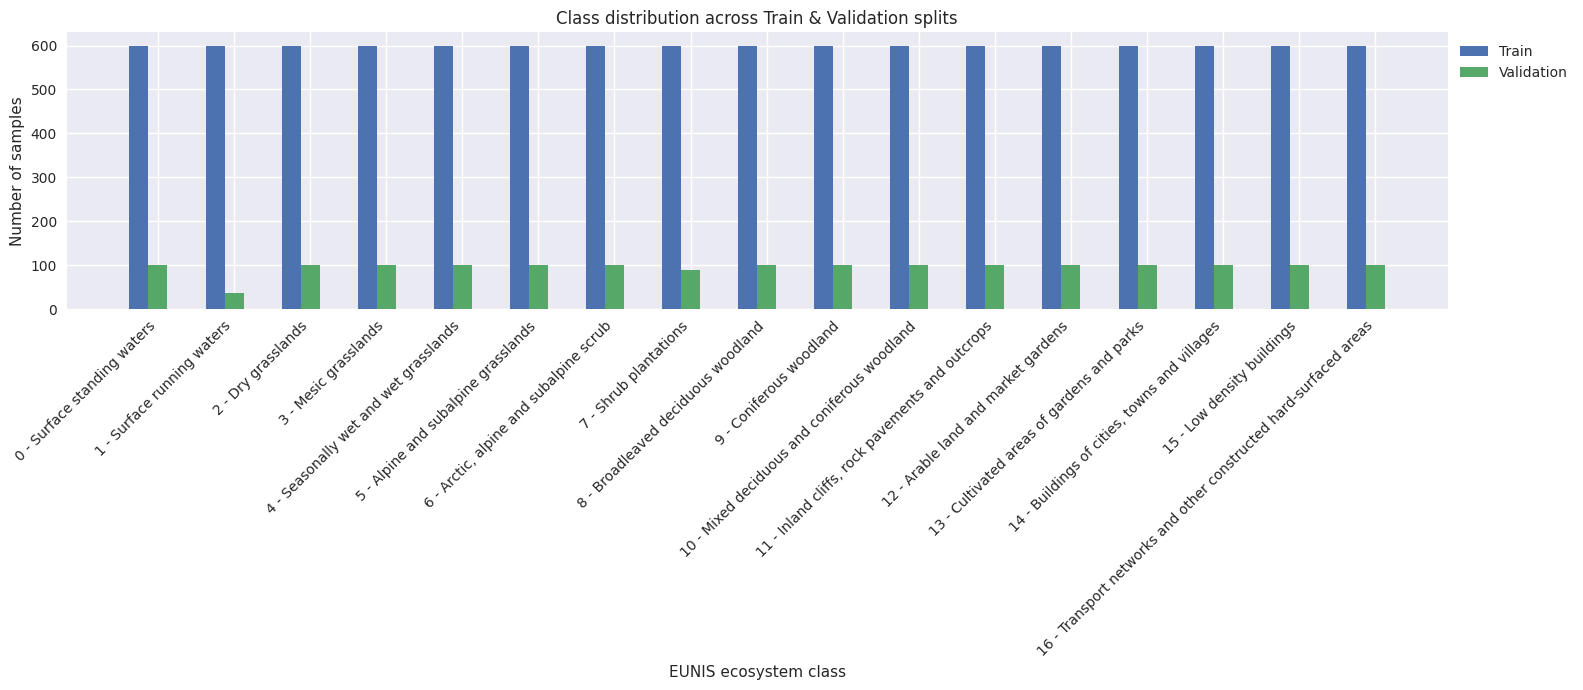

In [6]:
# Count samples per label per split
counts = (df_clean.groupby(['EUNIS_cls', 'EUNIS_label', 'split']).size().unstack(fill_value=0).loc[:, ['train', 'val', 'test']])

# Sort by class number (EUNIS_cls)
counts = counts.sort_index(level=0)

# Plot setup
x = np.arange(len(counts))
width = 0.25

plt.figure(figsize=(16, 7))
plt.bar(x - width, counts['train'], width, label='Train')
plt.bar(x,         counts['val'],   width, label='Validation')

# Rotate labels and show numeric class + label
xticks_labels = [f"{cls} - {label}" for cls, label in counts.index]
plt.xticks(x, xticks_labels, rotation=45, ha='right')

plt.ylabel("Number of samples")
plt.xlabel("EUNIS ecosystem class")
plt.title("Class distribution across Train & Validation splits")

# Place legend outside plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig(f"figures/class_distribution.png", dpi=300)
plt.show()

The training set shows an almost uniform distribution across the 17 ecosystem classes, while the validation set exhibits class imbalance, with some underrepresented classes such as Surface running waters (Class 1) and Shrub plantations (Class 7). This imbalance suggests that accuracy alone may be insufficient to properly assess model performance. Therefore, additional evaluation metrics, including macro-averaged F1 score, will be explored in later analyses to ensure balanced performance across all classes.

<a id="36"></a>

### 3.6 Environmental Variables (SWECO25)

The dataset includes 48 numerical variables, standardized to zero mean and unit variance, grouped into thematic categories:
- Bioclimatic
- Edaphic (soil)
- Vegetation
- Land use / land cover (LULC)
- Geology
- Hydrology
- Population and infrastructure

Thematic groupings are used to perform ablation studies.

We inspect the number of variables per SWECO thematic group.

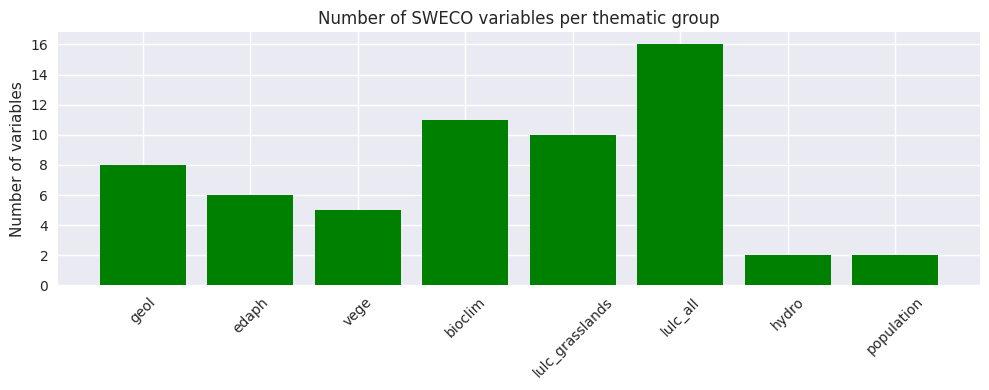

In [7]:
group_counts = {group: len(vars_list) for group, vars_list in sweco_variables_dict.items()}

plt.figure(figsize=(10,4))
plt.bar(group_counts.keys(), group_counts.values(), color='green')
plt.ylabel("Number of variables")
plt.title("Number of SWECO variables per thematic group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"figures/sweco_thematic_groups.png", dpi=300)
plt.show()

The 48 SWECO variables are unevenly distributed across the thematic groups. Some groups contain only a small number of variables (as few as two), while others are more densely represented, with the largest group comprising up to 16 variables. Most thematic groups include between 5 and 11 variables. This heterogeneous distribution is taken into account when performing ablation studies, as groups with more variables may contribute more strongly to model performance simply due to their higher dimensionality.

<a id="37"></a>

### 3.7 Aerial Images Overview
These high-resolution images capture fine-scale spatial patterns relevant for ecosystem discrimination.

- Source: swissIMAGE (swisstopo)
- Spatial resolution: 50 cm
- Image coverage: 100 × 100 meters
- RGB channels only

We first check if some images are missing relative to the Tabular data.

In [8]:
folder_path = Path("data/images_png") 

# List all PNG files in the folder and remove the '.png' extension
available_images = {f.stem for f in folder_path.glob("*.png")}

missing_images = set(df_clean['id'].astype(str)) - available_images
print(f"Missing images: {len(missing_images)}")

Missing images: 1


The missing image corresponds to the file that failed during the TIFF-to-PNG conversion step.

#### 3.7.1 Image loading function

The function below load the RGB aerial image from a png folder and return a PIL image in RGB format.

In [9]:
def load_image_from_folder(folder_path, img_id):
    """
    Load an RGB aerial image from a folder using tifffile (robust for GeoTIFF).
    Returns a PIL Image in RGB format.
    """
    img_path = Path(folder_path) / f"{img_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Image not found: {img_path}")

    # Read the image using PIL
    img = Image.open(img_path).convert("RGB")

    return img

#### 3.7.2 Apply the predefined split to images

For image data, the train/validation/test split is represented by lists of image identifiers. Images are loaded on-the-fly from the archive using these identifiers to avoid unnecessary memory usage.

In [10]:
png_folder = Path("data/images_png")
available_images = {f.stem for f in png_folder.glob("*.png")}

image_train_ids = [img_id for img_id in train_df['id'].tolist() if str(img_id) in available_images]
image_val_ids   = [img_id for img_id in val_df['id'].tolist() if str(img_id) in available_images]
image_test_ids  = [img_id for img_id in test_df['id'].tolist() if str(img_id) in available_images]

print(f"Number of training images: {len(image_train_ids)}")
print(f"Number of validation images: {len(image_val_ids)}")
print(f"Number of test images: {len(image_test_ids)}")


Number of training images: 10199
Number of validation images: 1625
Number of test images: 5100


We display a few random images from the training set to visualize ecosystem types.

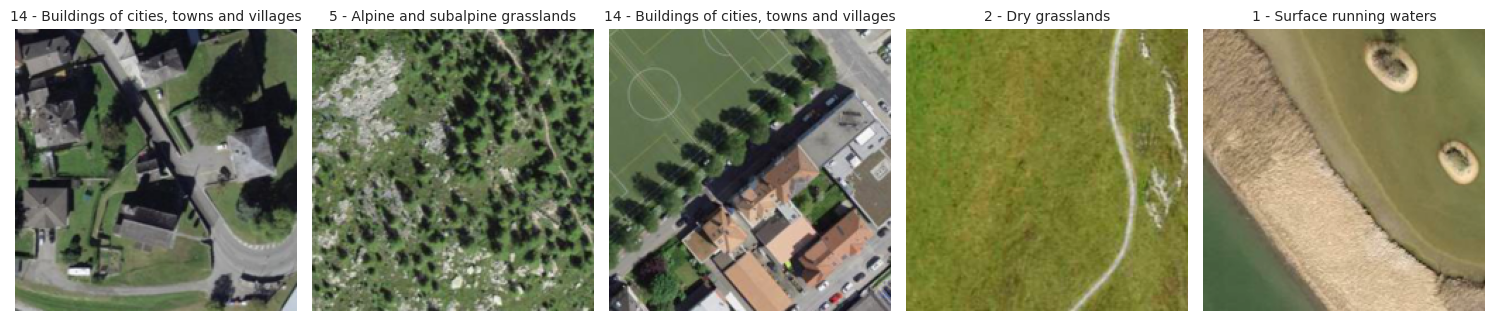

In [11]:
n_samples = 5

sample_rows = train_df.sample(n=n_samples, random_state=SEED)

fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_id = row['id']  
    img = load_image_from_folder("data/images_png", img_id)

    axes[i].imshow(img)
    axes[i].set_title(f"{row['EUNIS_cls']} - {row['EUNIS_label']}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This subset of training images show the difficulty to correctly map Ecosystems to region with changing surface properties.

## 4. Data Preprocessing

<a id="41"></a>

### 4.1 Image Preprocessing

Aerial RGB images are preprocessed using a sequence of standard transformations designed to ensure compatibility with convolutional neural networks (CNNs) and to improve model generalization. All images are first resized from their original 200 × 200 pixels (covering 100 × 100 m at 50 cm resolution) to a fixed spatial resolution of 224 × 224 pixels to match standard CNN backbones. They are then converted to tensors and normalized using ImageNet statistics, commonly employed for pretrained networks. This larger input preserves fine spatial details crucial for distinguishing ecosystem classes : smaller sizes were tested and, although faster to train, they consistently led to lower accuracy and macro F1 scores.

Although the spectral characteristics of aerial imagery differ from those of the ImageNet dataset, normalization with ImageNet mean and standard deviation provides a stable and widely adopted baseline. This practice has been shown to generalize well across domains and facilitates effective transfer learning from pretrained models.

Data augmentation is applied exclusively to the training set in order to reduce overfitting and increase robustness to variations in illumination and orientation. It increases the diversity of the training data without increasing the dataset size, by applying random transformations on-the-fly during training. The augmentation strategies used are standard in computer vision and were selected to enhance model robustness without altering the semantic content of the images:
- **Random resized cropping (224 × 224, scale ∈ [0.8, 1.0])**:
    Randomly crops a portion of the image and resizes it to the target resolution. This introduces robustness to scale variations and small spatial misalignments, while preserving most of the image content. Such transformations are particularly effective when training CNNs on high-resolution imagery.
- **Random horizontal and vertical flips** : Introduce orientation invariance, which is particularly important for aerial imagery where objects may appear in any direction.
- **Color jitter (brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)** : Applies controlled variations in illumination and color distribution, reducing sensitivity to lighting conditions, atmospheric effects, and sensor-specific differences. The chosen parameter values are commonly used in the literature and provide noticeable yet realistic variability.
- **Resizing to 224 × 224 pixels** : Ensures compatibility with standard CNN backbones such as ResNet and EfficientNet.
- **Normalization using ImageNet mean and standard deviation** : Aligns the input data distribution with that of pretrained weights, improving convergence and transfer learning performance.

Overall, these preprocessing and augmentation choices represent a well-established baseline. While they are not specifically tailored to aerial imagery, they provide a robust starting point and can be further refined if more domain-specific adjustments are required.

In [12]:
# Target image size (compatible with standard CNN backbones)
IMAGE_SIZE = 224

# ImageNet normalization statistics 
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Training image transformations (with augmentation)
train_image_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Validation / Test image transformations (no augmentation)
eval_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

Examples of transformations are shown below:

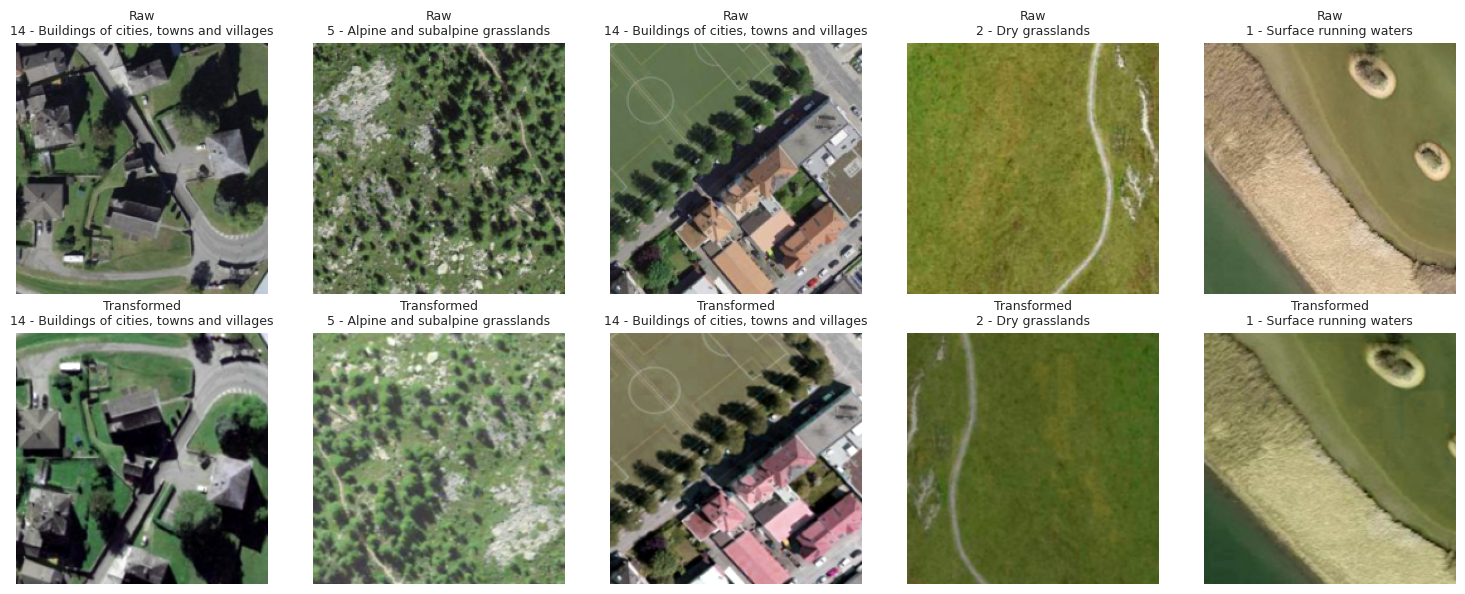

In [13]:
n_samples = 5
sample_rows = train_df.sample(n=n_samples, random_state=SEED)

fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_id = row['id']
    
    # --- Raw image ---
    raw_img = load_image_from_folder("data/images_png", img_id)
    axes[0, i].imshow(raw_img)
    axes[0, i].set_title(
        f"Raw\n{row['EUNIS_cls']} - {row['EUNIS_label']}", fontsize=9
    )
    axes[0, i].axis('off')
    
    # --- Transformed image (augmentation + normalization) ---
    img = train_image_transform(raw_img)         
    img = img.permute(1, 2, 0).numpy()             # C,H,W → H,W,C

    # Unnormalize ONLY for visualization
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)

    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Transformed\n{row['EUNIS_cls']} - {row['EUNIS_label']}", fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(f"figures/transformation_images.png", dpi=300)
plt.show()

<a id="42"></a>

### 4.2 Tabular Data Preprocessing

- Check missing values in SWECO variables

>**Note** : No standardization is required (the dataset was already standardized)

In [14]:
# Define non-variable columns
non_variable_cols = ['id', 'x', 'y', 'split', 'EUNIS_cls', 'EUNIS_label']

# All SWECO variables in the dataset
sweco_variables = [col for col in df_clean.columns if col not in non_variable_cols]
print(f"Number of SWECO variables: {len(sweco_variables)}")

# Check missing values
missing_counts = df_clean[sweco_variables].isna().sum()

# Display missing values with friendly message
if missing_counts.sum() == 0:
    print("No missing values across all SWECO variables.")
else:
    print("Missing values per SWECO variable:")
    print(missing_counts[missing_counts > 0])

Number of SWECO variables: 48
No missing values across all SWECO variables.


<a id="5"></a>
## 5. Methodology

<a id="51"></a>
### 5.1 Problem Formulation

The task is formulated as a multiclass classification problem with 17 mutually exclusive ecosystem classes.
Inputs:
- RGB aerial image
- Environmental variable vector

Output:
- Probability distribution over EUNIS classes

---

<a id="52"></a>

### 5.2 Image-Based Models

To address the EUNIS classification task from aerial imagery, convolutional neural networks (CNNs) pretrained on ImageNet are employed. Pretraining enables the models to leverage robust low- and mid-level visual features (e.g., edges, textures, and shapes), which is particularly beneficial given the limited size of the available dataset and improves generalization performance.

All image-based models in this study rely on ResNet-18 as a common backbone. ResNet-18 is a deep convolutional architecture composed of 18 layers and residual connections, which mitigate the vanishing gradient problem and allow for effective training of deep networks. Its strong representational capacity and widespread adoption make it a well-established choice for transfer learning in remote sensing and aerial image analysis.

Three distinct architectures are built upon this shared ResNet-18 backbone:

- **ResNet-18 Baseline**

    A standard fine-tuning approach in which the pretrained ResNet-18 backbone is followed by a classification head. This model serves as a strong reference point for evaluating more advanced feature aggregation strategies.
- **Hypercolumn ResNet-18**
    
    Globally pooled feature maps are extracted from multiple stages of the backbone (layer1 to layer4) and concatenated to form a hypercolumn representation. This design captures both fine-grained spatial details from shallow layers and high-level semantic information from deeper layers, enabling multi-scale feature learning.
- **CNN + Residual MLP**
    
    Global features extracted from the ResNet-18 backbone are pooled and passed through a residual multilayer perceptron (MLP) with skip connections. This architecture combines convolutional feature extraction with flexible fully connected modeling, allowing non-linear interactions among learned image features.

Across all image-based models, early layers of the backbone may be frozen while deeper layers and the classification head are fine-tuned. The final prediction is obtained through a global pooling operation followed by fully connected layers producing a 17-dimensional output corresponding to the target EUNIS classes.

By reusing a common ResNet-18 backbone, this framework enables a controlled comparison of different architectural strategies for image-based ecosystem classification.

#### 5.2.1 ResNet-18 Baseline
 A standard ResNet-18 pretrained on ImageNet is used as the backbone. Early convolutional layers (up to layer2) are frozen to retain pretrained low-level features, while the final block and classifier are fine-tuned. The final classification head outputs probabilities for 17 EUNIS classes. This serves as a strong baseline model

In [15]:
class ImageResNet18(nn.Module):
    def __init__(self, n_classes=17, pretrained=True, freeze_backbone=True):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.backbone = resnet18(weights=weights)
        
        # Optionally freeze early layers
        if freeze_backbone:
            for name, param in self.backbone.named_parameters():
                if not ("layer3" in name or "layer4" in name):
                    param.requires_grad = False
        
        # Replace final classifier
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, n_classes)

    def forward(self, x):
        return self.backbone(x)

#### 5.2.2 Hypercolumn ResNet-18
This model extracts multi-scale features from four stages of ResNet-18. Lower layers are frozen to preserve low-level representations, while deeper layers are fine-tuned. Each feature map is globally pooled and concatenated to form a hypercolumn vector, capturing both low-level textures and high-level semantic features. The hypercolumn is fed into an MLP classifier. This approach is particularly effective when fine spatial details are important.

In [16]:
class ImageHypercolumnResNet(nn.Module):
    def __init__(self, n_classes=17, dropout = 0.3, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        resnet = resnet18(weights=weights)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # Freeze low-level layers
        for name, param in self.layer0.named_parameters():
            param.requires_grad = False
        for name, param in self.layer1.named_parameters():
            param.requires_grad = False

        self.norm1 = nn.BatchNorm1d(64)
        self.norm2 = nn.BatchNorm1d(128)
        self.norm3 = nn.BatchNorm1d(256)
        self.norm4 = nn.BatchNorm1d(512)
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 + 128 + 256 + 512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        f0 = self.layer0(x)
        f1 = self.layer1(f0)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)

        # Global average pooling for each layer
        g0 = self.norm1(F.adaptive_avg_pool2d(f1, 1).view(x.size(0), -1))
        g1 = self.norm2(F.adaptive_avg_pool2d(f2, 1).view(x.size(0), -1))
        g2 = self.norm3(F.adaptive_avg_pool2d(f3, 1).view(x.size(0), -1))
        g3 = self.norm4(F.adaptive_avg_pool2d(f4, 1).view(x.size(0), -1))

        # Concatenate hypercolumn
        hc = torch.cat([g0, g1, g2, g3], dim=1)
        out = self.classifier(hc)
        return out
        

#### 5.2.3 CNN + Residual MLP
Features are first extracted using a ResNet-18 backbone. The pooled features are then fed into a residual MLP with skip connections and dropout for regularization. This hybrid design combines pretrained CNN features with flexible fully connected layers, providing a balance between model complexity and training stability

In [17]:
class ImageCNNFeatureMLP(nn.Module):
    def __init__(self, n_classes=17, pretrained=True, hidden_dim=256, n_blocks=2, dropout=0.3):
        super().__init__()
        # Pretrained backbone
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        resnet = resnet18(weights=weights)
        self.backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        )
        # Freeze early layers, fine-tune layer3 and layer4
        for i, layer in enumerate(self.backbone):
            if i < 6:
                for param in layer.parameters():
                    param.requires_grad = False

        self.pool = nn.AdaptiveAvgPool2d(1)
        in_dim = 512
        
        # Residual MLP
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(n_blocks):
            layers.append(ResidualBlock(hidden_dim, dropout))
        layers.append(nn.Linear(hidden_dim, n_classes))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.mlp(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(dim, dim), nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))

#### 5.2.4 Image DataLoader Function

To streamline training and evaluation, a dedicated function is implemented to generate PyTorch DataLoaders for image-based models.

**Purpose**: Load images from disk in batches, apply transformations on the fly (data augmentation for training and normalization for all samples), and associate each image with its corresponding class label.

**Implementation**: A custom Dataset class reads PNG images from a preprocessed image folder and applies the specified transformations during loading. Missing images are filtered out beforehand to ensure dataset consistency. The *make_image_dataloaders* function wraps the training and validation datasets into PyTorch DataLoaders, supporting reproducible shuffling and optional subsampling for efficient experimentation.

In [18]:
class FolderImageDataset(Dataset):
    """
    Reads images from a folder and applies transformations on the fly.
    Filters out missing images. Raises error if an image is unexpectedly missing.
    """
    def __init__(self, folder_path, image_ids, labels, transform=None, available_images=None):
        self.folder_path = folder_path
        self.transform = transform
        self.labels = np.array(labels)  # convert to numpy array for indexing

        # Check available images once
        if available_images is None:
            available_images = {f.replace('.png','') for f in os.listdir(folder_path) if f.endswith('.png')}
        self.available_images = available_images

        # Keep only valid IDs
        n_initial = len(image_ids)
        valid_idx = [i for i, img_id in enumerate(image_ids) if img_id in self.available_images]
        self.image_ids = [image_ids[i] for i in valid_idx]
        self.labels = self.labels[valid_idx]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        label = self.labels[idx]
        img_path = os.path.join(self.folder_path, f"{img_id}.png")

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Missing image: {img_path}")

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label


def make_image_dataloaders(folder_path, train_ids, val_ids, y_train, y_val, train_transform, val_transform, batch_size=32,
                           n_train_samples=None, num_workers=0, pin_memory=True, seed=42):
    """
    Create PyTorch DataLoaders for image-only training and validation.
    Supports taking a random subset of training samples.
    """
    # Take a random subset if requested
    if n_train_samples is not None and n_train_samples < len(train_ids):
        random.seed(seed)
        indices = random.sample(range(len(train_ids)), n_train_samples)
        train_ids = [train_ids[i] for i in indices]
        y_train = np.array(y_train)[indices]

    # Precompute available images once
    available_images = {f.replace('.png','') for f in os.listdir(folder_path) if f.endswith('.png')}

    # Create datasets
    train_dataset = FolderImageDataset(folder_path, train_ids, y_train, transform=train_transform, available_images=available_images)
    val_dataset   = FolderImageDataset(folder_path, val_ids, y_val, transform=val_transform, available_images=available_images)

    # Reproducible shuffling
    g = torch.Generator()
    g.manual_seed(seed)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader


<a id="53"></a>
### 5.3 Tabular-Only Model

To model the environmental variables, we rely on neural networks specifically designed for tabular data. All models take standardized SWECO variables as input and predict one of the 17 ecosystem classes. The architectures are designed to balance expressive power and regularization, given the moderate dimensionality of the input feature space.

**General design choices**

All tabular models share the following characteristics:
- Input: standardized SWECO environmental variables
- Hidden layers: fully connected (dense) layers
- Activation function: ReLU, chosen for its stability and efficiency
- Regularization:
    - Batch Normalization to stabilize training
    - Dropout to reduce overfitting
- Output: a fully connected layer with 17 neurons, followed by a softmax implicitly handled by the cross-entropy loss

#### 5.3.1 Standard Multilayer Perceptron (MLP)

The first architecture is a classical multilayer perceptron (MLP), which serves as a strong baseline for tabular data. The model consists of a sequence of fully connected layers with decreasing dimensionality. This pyramidal structure encourages the network to learn progressively more abstract representations of the input variables.

Batch normalization is applied after each linear transformation to improve convergence, followed by ReLU activation and dropout for regularization.

This architecture is simple, interpretable, and commonly used as a reference model for tabular classification tasks.

In [19]:
class TabularMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[512, 256, 128], dropout=0.3, n_classes=17):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

#### 5.3.2 Shallow Multilayer Perceptron (MLP)
A second shallow MLP architecture was tested to evaluate whether a simpler network can achieve comparable performance while reducing the risk of overfitting.

Key differences from the standard MLP:
- Fewer hidden layers and smaller number of neurons per layer.
- Same use of batch normalization, ReLU activations, and dropout.

This helps assess the influence of model complexity on performance.

In [20]:
class TabularShallowMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128, 32], dropout=0.3, n_classes=17):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

#### 5.3.3 MLP with Skip Connections (Residual MLP)

While standard MLPs can be effective, deeper networks may suffer from optimization difficulties such as vanishing gradients. To address this, we introduce a third architecture inspired by residual learning, originally proposed for deep convolutional networks.

This model first projects the input features into a fixed-dimensional latent space. It then applies a sequence of residual blocks, where each block learns a transformation that is added to its input. This skip connection allows gradients to flow more easily through the network and encourages the model to learn incremental refinements rather than entirely new representations at each layer.

Residual connections are particularly useful when increasing network depth without significantly degrading performance.

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(dim, dim), nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))


class TabularSkipMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, n_blocks=3, dropout=0.3, n_classes=17):
        super().__init__()

        # Input projection
        self.input_layer = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU())

        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_dim, dropout) for _ in range(n_blocks)])

        # Output head
        self.output_layer = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        return self.output_layer(x)

#### 5.3.4 Tabular DataLoader Function

This function creates PyTorch DataLoaders for the tabular training and validation sets. The input tensors are wrapped into a TensorDataset and loaded in batches with a specified batch size. The training DataLoader applies shuffling to improve generalization, while the validation DataLoader preserves the original data order. An optional subsampling mechanism allows selecting a random subset of the training data for efficient experimentation, with reproducible behavior ensured through a fixed random seed.

In [22]:
def make_dataloaders(Xtrain, ytrain, Xval, yval, batch_size=32, n_train_samples=None, seed=42):
    """
    Create DataLoaders for tabular data.
    If n_train_samples is set, randomly selects a subset of the training data.
    """
    if n_train_samples is not None and n_train_samples < len(Xtrain):
        np.random.seed(seed)
        indices = np.random.choice(len(Xtrain), n_train_samples, replace=False)
        Xtrain = Xtrain[indices]
        ytrain = ytrain[indices]

    train_dataset = TensorDataset(Xtrain, ytrain)
    val_dataset   = TensorDataset(Xval, yval)

    # --- Reproducible shuffling ---
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

<a id="54"></a>
### 5.4 Multimodal Model (Images + Environmental Variables)

To jointly exploit spatial information from aerial imagery and ecological context from environmental variables, a multimodal neural network architecture is proposed. The model consists of two parallel branches (one processing tabular data and the other processing images) followed by feature-level fusion and joint classification.

**Tabular branch**

Environmental variables are processed by a multilayer perceptron (MLP) composed of fully connected layers with batch normalization, ReLU activations, and dropout regularization. This branch maps the input feature vector to a compact latent representation that captures non-linear relationships among environmental variables.

**Image branch**

Image features are extracted using a convolutional neural network based on a ResNet-18 backbone. Different image-based architectures can be selected within the multimodal framework. They correspond to the Image previously defined model :
- a **standard ResNet-18 feature** extractor
- a **hypercolumn-based ResNet-18** capturing multi-scale representations
- a **CNN followed by a residual MLP** for feature refinement

In all cases, the image branch outputs a fixed-length feature vector, which is projected into a shared latent space before fusion.. When necessary, global average pooling is applied to convert spatial feature maps into a one-dimensional representation.

**Feature fusion and classification**

The latent representation from the tabular branch and a projected image feature representation are concatenated to form a joint feature vector. The relative contribution of image and tabular information is not fixed (e.g., 50/50), but is implicitly learned during training through the projection and classification layers, depending on the predictive usefulness of each modality. This fused representation is then passed through a fully connected classification head, producing a probability distribution over the 17 EUNIS ecosystem classes.

By integrating complementary visual and environmental information at the feature level, this multimodal architecture enables the model to leverage both spatial patterns visible in aerial imagery and ecological context provided by tabular variables, leading to improved ecosystem classification performance compared to unimodal approaches.

In [23]:
class CombinedTabularImageModel(nn.Module):
    """
    Combines tabular data (MLP) and images (CNN) for classification.
    Possibility to choose the CNN architecture (from the Image defined).
    """
    def __init__(self, tabular_input_dim, n_classes=17, tabular_hidden=[256, 128], image_model='Resnet18', pretrained=True, dropout=0.3):
        super().__init__()

        # --- Tabular branch ---
        layers = []
        input_dim = tabular_input_dim
        for h in tabular_hidden:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = h
        self.tabular_mlp = nn.Sequential(*layers)
        tabular_feat_dim = tabular_hidden[-1]

        # --- Image branch ---
        if image_model == 'Resnet18':
            # Return feature vector instead of logits
            self.image_model = ImageResNet18(n_classes=512, pretrained=pretrained, freeze_backbone=True)
            self.image_feat_dim = 512
        elif image_model == 'Hypercolumn':
            self.image_model = ImageHypercolumnResNet(n_classes= 64 + 128 + 256 + 512, dropout=dropout, pretrained=pretrained)
            self.image_feat_dim = 64 + 128 + 256 + 512
        elif image_model == 'CNNfeature':
            self.image_model = ImageCNNFeatureMLP(n_classes=256, pretrained=pretrained, hidden_dim=256, dropout=dropout)
            self.image_feat_dim = 256
        else:
            raise NotImplementedError(f"{image_model} not supported")

        # --- Fusion classifier ---
        self.img_proj = nn.Sequential(
            nn.Linear(self.image_feat_dim, tabular_feat_dim),
            nn.BatchNorm1d(tabular_feat_dim),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(2*tabular_feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, n_classes)
        )

    def forward(self, tabular_x, image_x):
        # Tabular branch
        tab_feat = self.tabular_mlp(tabular_x)
        
        # Image branch
        img_feat = self.image_model(image_x)
        if img_feat.ndim == 4:  # if backbone returns (B,C,H,W)
            img_feat = F.adaptive_avg_pool2d(img_feat, 1).view(img_feat.size(0), -1)

        # Concatenate features
        img_feat = self.img_proj(img_feat)
        combined = torch.cat([tab_feat, img_feat], dim=1)
        out = self.classifier(combined)
        return out

#### 5.4.1 Tabular DataLoader Function

A custom dataset is implemented to jointly load tabular environmental variables and corresponding RGB aerial images for each sample. Tabular features are provided as preprocessed tensors, while images are loaded on-the-fly from a compressed archive and converted to RGB format when necessary. Only samples with valid image identifiers are retained to ensure consistency between modalities. Standard image preprocessing and augmentation are applied, with augmentation restricted to the training set. Dedicated data loaders are used to create training and validation splits, with optional subsampling of the training set for controlled experiments. Shuffling of the training set is reproducible via a fixed random seed.

In [24]:
class CombinedDataset(Dataset):
    """
    Returns (tabular_features, image, label) for multimodal training.
    """
    def __init__(self, tabular_tensor, df, folder_path, image_ids, labels_column='EUNIS_cls', transform=None):
        """
        tabular_tensor : torch.Tensor of shape (N, n_features)
        df             : pandas DataFrame containing image IDs
        folder_path    : path to folder with images
        image_ids      : list of image IDs corresponding to df rows
        labels_column  : column name for labels in df
        transform      : torchvision transforms for images
        """
        self.tabular_tensor = tabular_tensor
        self.image_ids = image_ids
        self.labels = torch.tensor(df[labels_column].values, dtype=torch.long)
        self.transform = transform
        self.folder_path = folder_path

        # Preload available images
        self.available_images = {f.replace('.png','') for f in os.listdir(folder_path) if f.endswith('.png')}
            
        # Keep only valid IDs
        valid_idx = [i for i, img_id in enumerate(self.image_ids) if img_id in self.available_images]
        self.tabular_tensor = self.tabular_tensor[valid_idx]
        self.image_ids = [self.image_ids[i] for i in valid_idx]
        self.labels = self.labels[valid_idx]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        tab_feat = self.tabular_tensor[idx]
        label = self.labels[idx]

        img_id = self.image_ids[idx]
        img_path = os.path.join(self.folder_path, f"{img_id}.png")

        if not os.path.exists(img_path):
            # fallback black image
            img = Image.new("RGB", (224,224), (0,0,0))
        else:
            img = Image.open(img_path).convert("RGB")  # ensures 3-channel RGB

        if self.transform:
            img = self.transform(img)

        return tab_feat, img, label
    


def make_combined_dataloaders(tabular_train, tabular_val, train_df, val_df, folder_path, train_ids, val_ids,
                              train_transform, val_transform, batch_size=32, n_train_samples=None, n_workers=0, pin_memory=False, seed=42):
    """
    Create DataLoaders for combined tabular + image data.
    Can take a random subset of the training set via n_train_samples.
    """
    # Select a subset if requested
    if n_train_samples is not None and n_train_samples < len(train_ids):
        random.seed(seed)
        indices = random.sample(range(len(train_ids)), n_train_samples)
        train_ids = [train_ids[i] for i in indices]
        tabular_train = tabular_train[indices]
        train_df = train_df.iloc[indices].reset_index(drop=True)

    train_dataset = CombinedDataset(tabular_train, train_df, folder_path, train_ids, transform=train_transform)
    val_dataset   = CombinedDataset(tabular_val, val_df, folder_path, val_ids, transform=val_transform)

    # --- Reproducible shuffling ---
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g, num_workers = n_workers, pin_memory=pin_memory)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory = pin_memory)

    return train_loader, val_loader

<a id="55"></a>

### 5.5 Loss Function and Optimization

Ecosystem prediction is a multiclass classification task with mutually exclusive classes.  
We use **categorical cross-entropy** as the loss function. The original training data does not have class imbalance but in case of selecting of subset, a **class-weighted cross-entropy** can be automatically computed from the training labels.  

The optimizer is **Adam**, optionally with weight decay, and the learning rate can be scheduled during training.  

The following function *get_loss_optimizer* conveniently returns the criterion and optimizer. By setting `weighted=True`, it computes class weights automatically from the training labels.

In [25]:
def get_loss_optimizer(model, ytrain=None, lr=1e-3, weight_decay=0.0, weighted=False, device='cpu'):
    """
    Returns a criterion and optimizer for training a model.
    If weighted=True, computes class weights automatically from ytrain.
    
    Args:
        model: torch.nn.Module, the model to optimize
        ytrain: array-like, training labels (required if weighted=True)
        lr: float, learning rate
        weight_decay: float, weight decay for Adam optimizer
        weighted: bool, whether to use class-weighted loss
        
    Returns:
        criterion: loss function
        optimizer: optimizer
    """
    if weighted:
        if ytrain is None:
            raise ValueError("ytrain must be provided when weighted=True")
        classes = np.unique(ytrain)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytrain)
        class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    return criterion, optimizer

<a id="6"></a>
## 6. Experimental Design

<a id="61"></a>
### 6.1 Compared Models

The following models are evaluated:
- Image-only model
- Tabular-only model (all SWECO variables)
- Multimodal model (image + all variables)

---

<a id="62"></a>
### 6.2 Ablation Study on Environmental Variables

We compute the contribution of individual SWECO variables by measuring the decrease in model performance (accuracy or chosen metric) when each feature is randomly permuted across the validation or test set. The resulting percentage importance represents the average drop in performance caused by perturbing that feature, indicating how much the model relies on it. Features are also grouped thematically, allowing calculation of mean importance per group.

The *compute_group_permutation_importance* function returns both individual feature importances and group-level means, while *plot_permutation_importances visualizes* the top features and relative contribution of each feature group. This approach provides a fast, ablation-style analysis without needing to retrain multiple models, highlighting which ecological drivers are most informative for ecosystem prediction.

In [26]:
def compute_group_permutation_importance(model, X, y, feature_names, feature_groups, metric=accuracy_score, n_repeats=5, device='cpu'):
    """
    Compute permutation importance of features and aggregate by predefined groups.

    Args:
        model: Trained PyTorch model
        X: Input features (torch.Tensor)
        y: True labels (torch.Tensor)
        feature_names: List of feature names corresponding to X columns
        feature_groups: Dictionary mapping group_name -> list of feature names
        metric: Function to evaluate performance (default: accuracy_score)
        n_repeats: Number of permutations for stability

    Returns:
        feature_importances_pct: np.array of feature importances (% drop in metric)
        group_importances: dict of mean importance per group (%)
    """
    model = model.to(device)
    model.eval()
    X = X.to(device)
    y = y.to(device)

    n_features = X.shape[1]
    importances = np.zeros(n_features)

    # Base prediction
    with torch.no_grad():
        base_preds = torch.argmax(model(X), dim=1)
        base_score = metric(y.cpu().numpy(), base_preds.cpu().numpy())
    
    # Permutation
    for col in range(n_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            perm = torch.randperm(X.shape[0])
            X_permuted[:, col] = X_permuted[perm, col]
            with torch.no_grad():
                preds = torch.argmax(model(X_permuted), dim=1)
            scores.append(base_score - metric(y.cpu().numpy(), preds.cpu().numpy()))
        importances[col] = np.mean(scores)

    feature_importances_pct = importances * 100

    # Aggregate by group
    group_importances = {}
    for group_name, group_features in feature_groups.items():
        idx = [i for i, f in enumerate(feature_names) if f in group_features]
        if len(idx) > 0:
            group_importances[group_name] = feature_importances_pct[idx].mean()
        else:
            group_importances[group_name] = 0.0

    return feature_importances_pct, group_importances


def plot_permutation_importances(feature_importances_pct, feature_names, group_importances, top_n=20, save_path_top=None, save_path_group=None):
    """
    Plot top N feature importances and group-level mean importances.

    Args:
        feature_importances_pct: np.array of feature importances (%)
        feature_names: list of feature names
        group_importances: dict mapping group_name -> mean importance (%)
        top_n: number of top features to display
        save_path_top: str, optional path to save top features figure
        save_path_group: str, optional path to save group-level figure
    """
    # --- Top features ---
    top_idx = np.argsort(feature_importances_pct)[-top_n:][::-1]
    plt.figure(figsize=(10,5))
    plt.barh(range(top_n), feature_importances_pct[top_idx])
    plt.yticks(range(top_n), np.array(feature_names)[top_idx])
    plt.gca().invert_yaxis()
    plt.xlabel("Permutation Importance (%)")
    plt.title(f"Top {top_n} SWECO Features")
    plt.tight_layout()
    if save_path_top:
        plt.savefig(save_path_top, dpi=300)
    plt.show()

    # --- Group-level importances ---
    groups_sorted = sorted(group_importances.items(), key=lambda x: x[1], reverse=True)
    plt.figure(figsize=(6,4))
    plt.bar([g[0] for g in groups_sorted], [g[1] for g in groups_sorted])
    plt.xticks(rotation=45)
    plt.ylabel("Mean Permutation Importance (%)")
    plt.title("Permutation Importance by Feature Group")
    plt.tight_layout()
    if save_path_group:
        plt.savefig(save_path_group, dpi=300)
    plt.show()

<a id="63"></a>
### 6.3 Training Setup and Hyperparameter Selection

#### 6.3.1 Hyperparameter Selection

The tabular MLP models are trained in a **supervised classification setup**, with hyperparameters tuned on the validation set to optimize predictive performance.

**Explored hyperparameters and their effects**:
- **Learning rate (1e-4, 3e-4, 1e-3):**
    - Controls the step size during gradient descent. Smaller values provide more stable but slower convergence, while larger values can speed up training but risk overshooting minima.
- **Batch size (16, 32):**
    - Determines the number of samples per gradient update. Smaller batches introduce more noise in gradient estimation, which can improve generalization; larger batches provide more stable updates but may converge to sharper minima.
- **Dropout rate (0.2, 0.5):**
     - Regularization technique that randomly zeroes a fraction of layer outputs during training. Higher dropout prevents overfitting but can slow convergence.
- **Weight decay (0, 1e-4):**
    - L2 regularization applied to the network weights to reduce overfitting. Larger values encourage smaller weights and smoother solutions.

**Selection criterion**:
The best configuration is chosen based on validation macro F1-score, which accounts for class imbalance.

**Regularization / stopping**:
- Early stopping is applied to prevent overfitting.
- Dropout and optional weight decay help regularize the network and improve generalization.

**Practical choices for this project**:
To balance thorough exploration with feasible training time, a reduced set of three hyperparameter combinations was selected. This subset captures a range of learning rates, batch sizes, dropout rates, and weight decay, allowing systematic comparison across model architectures in Chapter 8.

In [27]:
hparams_list = [
    {"learning_rate": 1e-4, "batch_size": 16, "dropout_rate": 0.2, "weight_decay": 0},
    {"learning_rate": 3e-4, "batch_size": 16, "dropout_rate": 0.5, "weight_decay": 0},
    {"learning_rate": 1e-3, "batch_size": 32, "dropout_rate": 0.2, "weight_decay": 1e-4},
]

#### 6.3.2 Tensor and Dataset Initialization

Tabular SWECO features and their corresponding labels are converted into PyTorch tensors (float32 for inputs, long for class labels) and moved to the selected device (CPU or GPU) to enable efficient batch training. Image and combined datasets are handled separately in Chapter 8.

In [28]:
# Training tensors
Xtrain_tensor = torch.tensor(train_df[sweco_variables].values, dtype=torch.float32).to(device)
ytrain_tensor = torch.tensor(train_df['EUNIS_cls'].values, dtype=torch.long).to(device)

# Validation tensors
Xval_tensor = torch.tensor(val_df[sweco_variables].values, dtype=torch.float32).to(device)
yval_tensor = torch.tensor(val_df['EUNIS_cls'].values, dtype=torch.long).to(device)

# Test tensors
Xtest_tensor = torch.tensor(test_df[sweco_variables].values, dtype=torch.float32).to(device)
ytest_tensor = torch.tensor(test_df['EUNIS_cls'].values, dtype=torch.long).to(device)


#### 6.3.3 Model Training and Validation

This function trains a given model over multiple epochs using the provided DataLoaders. For each epoch, it:
- Computes training loss, accuracy, and macro F1-score.
- Evaluates the model on the validation set, calculating the same metrics.
- Supports tabular, image-only, or combined tabular+image models by checking batch content.
- Tracks the epoch with the highest validation F1-score and automatically saves the corresponding model state along with its hyperparameters and model type.
- Returns a history dictionary containing training and validation metrics per epoch, as well as epoch durations, enabling monitoring and visualization of training progress.

Regularization strategies such as dropout and weight decay can be applied through the hyperparameters passed to the optimizer.

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=100, save_path='best_tabular_model.pt', print_every=10, device='cpu',
               hparams=None, selected_model=None, selected_image_model=None):
    """
    Trains the given model and evaluates on validation set per epoch.
    Stores the model with the best validation F1-score.

    Returns:
        history (dict): Train/validation metrics and epoch times
        best_epoch (int): Epoch with best validation F1
        total_time (float): Total training time in seconds
    """
    best_val_f1 = 0.0
    best_epoch = 0

    history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_acc": [], "val_f1": [], "epoch_time": []}

    total_start = time.time()

    for epoch in range(1, n_epochs + 1):
        start_epoch = time.time()
        model.train()

        train_losses = []
        train_preds, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()

            if len(batch) == 3:
                tabular_batch, image_batch, labels = batch
                tabular_batch = tabular_batch.to(device)
                image_batch = image_batch.to(device)
                labels = labels.to(device)
                preds = model(tabular_batch, image_batch)  # Combined model
            elif len(batch) == 2:
                xb, labels = batch
                xb = xb.to(device)
                labels = labels.to(device)
                preds = model(xb)  # Tabular or image-only model
            else:
                raise ValueError(f"Unexpected batch format: {batch}")
            
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_preds.append(preds.detach())
            train_labels.append(labels)

        # --- Train metrics ---
        avg_train_loss = sum(train_losses) / len(train_losses)
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)

        train_acc = accuracy_score(train_labels.detach().cpu().numpy(),
                                   train_preds.argmax(1).detach().cpu().numpy())
        train_f1  = f1_score(train_labels.detach().cpu().numpy(),
                             train_preds.argmax(1).detach().cpu().numpy(), average='macro')
        # --- Validation ---
        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    tabular_batch, image_batch, labels = batch
                    tabular_batch = tabular_batch.to(device)
                    image_batch = image_batch.to(device)
                    labels = labels.to(device)
                    preds = model(tabular_batch, image_batch)
                elif len(batch) == 2:
                    xb, labels = batch
                    xb = xb.to(device)
                    labels = labels.to(device)
                    preds = model(xb)
                else:
                    raise ValueError(f"Unexpected batch format: {batch}")
                
                val_preds.append(preds)
                val_labels.append(labels)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_acc = accuracy_score(val_labels.detach().cpu().numpy(), val_preds.argmax(1).detach().cpu().numpy())
        val_f1  = f1_score(val_labels.detach().cpu().numpy(), val_preds.argmax(1).detach().cpu().numpy(), average='macro')

        # --- Save best ---
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save({'model_state_dict': model.state_dict(),
                        'hyperparameters': hparams,
                        'model_type': selected_model,
                        'image_model': selected_image_model if selected_model=='Combined' else None}, model_path)

        # --- Store history ---
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["epoch_time"].append(time.time() - start_epoch)

        if epoch % print_every == 0 or epoch == 1:
            print(
                f"Epoch {epoch}/{n_epochs} | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Train Acc: {train_acc:.3f}, Train F1: {train_f1:.3f} | "
                f"Val Acc: {val_acc:.3f}, Val F1: {val_f1:.3f}"
            )

    total_time = time.time() - total_start

    return history, best_epoch, total_time

<a id="7"></a>
## 7. Evaluation Metrics
<a id="71"></a>
### 7.1 Classification Metrics

The following metrics are computed on train, validation, and test sets:
- Overall accuracy
- Macro-averaged F1-score
- Per-class F1-score
- Confusion matrix

Macro-averaged metrics are emphasized to ensure fair evaluation of rare ecosystem classes.

The *evaluate_model* function computes overall accuracy, macro F1, and per-class F1 for a given model and dataset.

In [30]:
def evaluate_model_dataloader(model, dataloader, model_type):
    model.eval()
    device = next(model.parameters()).device
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            if model_type in ['Resnet18', 'Hypercolumn', 'CNNfeature']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                outputs = model(X)
            elif model_type in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                outputs = model(X)
            elif model_type == 'Combined':
                X_tab, X_img, y = batch
                X_tab, X_img, y = X_tab.to(device), X_img.to(device), y.to(device)
                outputs = model(X_tab, X_img)
            else:
                raise ValueError(f"Unknown model type: {model_type}")

            preds = outputs.argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = accuracy_score(all_labels.numpy(), all_preds.numpy())
    f1_macro = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
    f1_per_class = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)

    return acc, f1_macro, f1_per_class


The *plot_per_class_f1* fuction displays a bar chart of F1 scores for each class, optionally showing class names.

In [31]:
def plot_per_class_f1(f1_per_class, class_numbers, class_names, title="Per-Class F1 Score", save_path=None):
    """
    Plot per-class F1 scores, showing class number and name.

    Args:
        f1_per_class (array-like): F1 score for each class
        Class_numbers (list): Numeric class IDs (e.g. [0, 1, 2, ...])
        class_names (list): Class names aligned with class_numbers
        title (str): Plot title
    """
    sorted_idx = np.argsort(class_numbers)
    sorted_numbers = np.array(class_numbers)[sorted_idx]
    sorted_names = np.array(class_names)[sorted_idx]
    sorted_f1 = np.array(f1_per_class)[sorted_idx]

    # Create labels "id - name"
    labels = [f"{num} - {name}" for num, name in zip(sorted_numbers, sorted_names)]
    
    plt.figure(figsize=(12,8))
    plt.bar(np.arange(len(sorted_f1)), sorted_f1, color='skyblue')
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.ylabel("F1 Score")
    plt.xlabel("Class")
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

The *plot_confusion_matrix* function plots a (normalized) confusion matrix to visualize per-class prediction performance.

In [32]:
def plot_confusion_matrix(y_true, y_pred, class_numbers, class_names, figsize=(10,10), normalize=True, cmap='Blues', title="Confusion Matrix", save_path=None):
    """
    Plots the confusion matrix with class numbers and labels sorted by numeric class.
    
    Args:
        y_true: array-like, true labels (int indices)
        y_pred: array-like, predicted labels (int indices)
        class_numbers: list of numeric class IDs (e.g., [0, 1, 2, ...])
        class_names: list of class names (e.g., ['Forest', 'Grassland', ...])
        figsize: tuple, figure size
        normalize: bool, whether to show percentages
        cmap: colormap
        title: figure title
        save_path: optional path to save figure
    """

    # Move tensors to CPU and convert to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()

    # Sort classes by numeric ID
    sorted_idx = np.argsort(class_numbers)
    sorted_numbers = [class_numbers[i] for i in sorted_idx]
    sorted_names   = [class_names[i] for i in sorted_idx]
    sorted_labels  = [f"{num} - {name}" for num, name in zip(sorted_numbers, sorted_names)]

    # Compute confusion matrix and reorder rows/cols
    cm = confusion_matrix(y_true, y_pred)
    cm = cm[sorted_idx][:, sorted_idx]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.1f'
    else:
        fmt = 'd'
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Add color bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Proportion' if normalize else 'Count', rotation=-90, va="bottom")

    # Show all ticks and labels
    ax.set_xticks(np.arange(len(sorted_labels)))
    ax.set_yticks(np.arange(len(sorted_labels)))
    ax.set_xticklabels(sorted_labels, rotation=90, fontsize=10)
    ax.set_yticklabels(sorted_labels, fontsize=10)
    
    # Add text annotations inside cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            # Skip annotation if zero (or very close to zero for normalized matrix)
            if np.isclose(val, 0.0):
                continue
            ax.text(j, i, format(val, fmt), ha="center", va="center", color="white" if val > thresh else "black", fontsize=9)
    
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

The *plot_training_curves* function plots accuracy and macro F1 over epochs for training and validation sets, optionally saving the figure.

In [33]:
def plot_training_curves(history, save_path=None):
    epochs = range(1, len(history["train_acc"]) + 1)

    plt.figure(figsize=(12,5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", linewidth=1)
    plt.plot(epochs, history["val_acc"], label="Val Accuracy", linewidth=1)
    plt.plot(epochs, history["train_f1"], '--', label="Train Macro F1")
    plt.plot(epochs, history["val_f1"], '--', label="Val Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Training and Validation Performance")
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")    
    plt.show()

<a id="72"></a>
### 7.2 Computational Performance

Computational efficiency is assessed by measuring:
- Average training time per epoch
- Total training time
- Inference time per sample

In [34]:
def measure_inference_time(model, X, device='cpu'):
    """
    Measures average inference time per sample.

    X can be:
      - torch.Tensor (tabular)
      - tuple of tensors (tabular, image)
      - DataLoader (image-only or combined in batches)
    """
    model.eval()
    model.to(device)
    total_time = 0.0
    n_samples = 0
    with torch.no_grad():
        if isinstance(X, torch.Tensor):
            X = X.to(device)
            start = time.time()
            _ = model(X)
            total_time = time.time() - start
            n_samples = X.shape[0]

        elif isinstance(X, tuple):
            X_tab, X_img = X
            X_tab = X_tab.to(device)
            X_img = X_img.to(device)
            start = time.time()
            _ = model(X_tab, X_img)
            total_time = time.time() - start
            n_samples = X_tab.shape[0]

        elif isinstance(X, DataLoader):
            for batch in X:
                if len(batch) == 2:  # tabular or image-only
                    inputs, _ = batch
                    inputs = inputs.to(device)
                    start = time.time()
                    _ = model(inputs)
                    total_time += time.time() - start
                    n_samples += inputs.shape[0]
                elif len(batch) == 3:  # combined
                    X_tab, X_img, _ = batch
                    X_tab = X_tab.to(device)
                    X_img = X_img.to(device)
                    start = time.time()
                    _ = model(X_tab, X_img)
                    total_time += time.time() - start
                    n_samples += X_tab.shape[0]
        else:
            raise ValueError("Unsupported input type for measure_inference_time.")
    
    return total_time / n_samples

<a id="8"></a>
## 8. Hyperparameter & Model Exploration
<a id="81"></a>
### 8.1 Quantitative Results on Training and Validation Set

#### 8.1.1 Selection of parameters and model

>**Note on training setup**:
Tabular models were trained on the full dataset for up to 200 epochs, benefiting from extended optimization at low computational cost. Image-based models were trained on a 4,000-sample subset for 30 epochs, as per-epoch training is slower and validation performance plateaued earlier. Occasionally, validation metrics exceeded training due to regularization (dropout, batch norm, augmentation).

>Each hyperparameter configuration (indexed in `hparams_list`) was tested for every architecture to systematically evaluate their effect. The `weighted=True` flag for cross-entropy loss was always kept: on the full training set, which has equal class frequencies, it does not change results, but it helps when training on a smaller subset to avoid bias toward more frequent classes. Using a subset allowed efficient exploration of architectures and hyperparameters while capturing representative performance trends; more samples would shift the performance plateau to later epochs, increasing total training time.



In [35]:
# 1. Selection of parameters
hparams_index = 2           # [0-2]
n_epochs = 30
n_train_samples = 4000      # None = number max : 10'200
weighted = True            # weighted cross entropy (only relevant if using a subset)

hparams = hparams_list[hparams_index]

# 2. Choose main model
model_choices = ['TabularStandard', 'TabularSkip', 'TabularShallow','Resnet18', 'Hypercolumn', 'CNNfeature', 'Combined']

selected_model = model_choices[6]  # change index to choose main model [0-6]

# 2b. If using combined model, choose image backbone
image_choices = ['Resnet18', 'Hypercolumn', 'CNNfeature']

selected_image_model = image_choices[2]  # change index for combined model [0-2]

#### 8.1.2 Experiment running
**Experiment setup and execution:**  
1. **Dataloaders & model selection:** Depending on the chosen architecture (`Tabular`, `Image`, or `Combined`), appropriate training and validation DataLoaders are created, and the corresponding model is initialized with the selected hyperparameters.  
2. **Dataset info & naming:** The number of training and validation samples is displayed. A clean experiment name is generated for saving model weights and figures.  
3. **Loss & optimizer:** Cross-entropy loss (weighted if relevant) and optimizer are initialized according to the selected hyperparameters.  
4. **Training:** The model is trained for the specified number of epochs, saving the checkpoint with the best validation F1-score.  
5. **Best model loading & evaluation:** The best model weights are loaded, and validation performance (accuracy and macro F1) is computed.  
6. **Computational performance:** Total training time and average epoch duration are reported.  
7. **Visualization:** Training curves are plotted, and permutation feature importance is computed for tabular models.  
8. **Logging:** All hyperparameters, performance metrics, and computational stats are saved in a CSV for record-keeping.


Number of training samples: 4000, Number of validation samples: 1625
Model : Combined_CNNfeature_2
Hyperparameters used : {'learning_rate': 0.001, 'batch_size': 32, 'dropout_rate': 0.2, 'weight_decay': 0.0001}
Epoch 1/30 | Train Loss: 1.8487 | Train Acc: 0.404, Train F1: 0.389 | Val Acc: 0.460, Val F1: 0.419
Epoch 2/30 | Train Loss: 1.4001 | Train Acc: 0.527, Train F1: 0.517 | Val Acc: 0.518, Val F1: 0.480
Epoch 4/30 | Train Loss: 1.2495 | Train Acc: 0.567, Train F1: 0.560 | Val Acc: 0.519, Val F1: 0.494
Epoch 6/30 | Train Loss: 1.1921 | Train Acc: 0.601, Train F1: 0.594 | Val Acc: 0.534, Val F1: 0.506
Epoch 8/30 | Train Loss: 1.1336 | Train Acc: 0.606, Train F1: 0.600 | Val Acc: 0.506, Val F1: 0.481
Epoch 10/30 | Train Loss: 1.0880 | Train Acc: 0.621, Train F1: 0.614 | Val Acc: 0.500, Val F1: 0.480
Epoch 12/30 | Train Loss: 1.0509 | Train Acc: 0.626, Train F1: 0.620 | Val Acc: 0.519, Val F1: 0.498
Epoch 14/30 | Train Loss: 1.0165 | Train Acc: 0.636, Train F1: 0.630 | Val Acc: 0.516, V

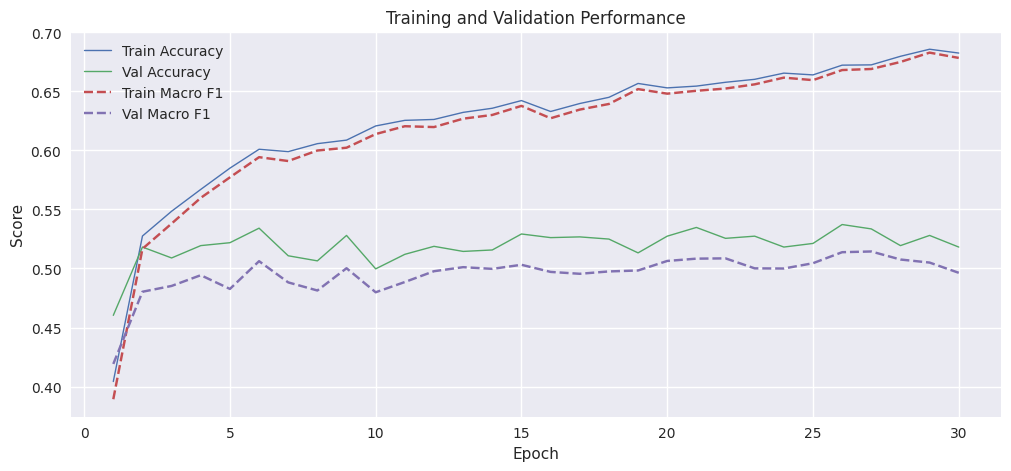

Permutation importance not computed for non-tabular models.


In [71]:
# 1. Dataloaders and model
input_dim = Xtrain_tensor.shape[1]

# --- Tabular models --- #
if selected_model in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
    # Tabular dataloaders
    train_loader, val_loader = make_dataloaders(Xtrain_tensor, ytrain_tensor, Xval_tensor, yval_tensor, batch_size=hparams['batch_size'], n_train_samples=n_train_samples)
    # Tabular models
    if selected_model == 'TabularStandard':
        model = TabularMLP(input_dim=input_dim, hidden_layers = [512,256,128], dropout=hparams['dropout_rate'], n_classes=17)
    elif selected_model == 'TabularSkip':
        model = TabularSkipMLP(input_dim=input_dim, hidden_dim=256, n_blocks=3, dropout=hparams["dropout_rate"], n_classes=17)
    else : 
        model = TabularShallowMLP(input_dim=input_dim, hidden_layers = [128,32], dropout=hparams['dropout_rate'], n_classes=17)

# --- Image models --- #
elif selected_model in ['Resnet18', 'Hypercolumn', 'CNNfeature']:
    # Image dataloaders
    train_loader, val_loader = make_image_dataloaders(folder_path="data/images_png", train_ids=image_train_ids, val_ids=image_val_ids,
        y_train=train_df['EUNIS_cls'].values, y_val=val_df['EUNIS_cls'].values, train_transform=train_image_transform, val_transform=eval_image_transform,
        batch_size=hparams['batch_size'], n_train_samples=n_train_samples, num_workers=0, pin_memory=True, seed=42)
    # Image models
    if selected_model == 'Resnet18':
        model = ImageResNet18(n_classes=17, pretrained=True)
    elif selected_model == 'Hypercolumn':
        model = ImageHypercolumnResNet(n_classes=17, dropout=hparams['dropout_rate'], pretrained=True)
    else:
        model = ImageCNNFeatureMLP(n_classes=17, pretrained=True, hidden_dim=256, n_blocks=2, dropout=hparams['dropout_rate'])

# --- Combined models --- #
elif selected_model == 'Combined':
    # Combined dataloaders
    train_loader, val_loader = make_combined_dataloaders(Xtrain_tensor, Xval_tensor, train_df, val_df, folder_path="data/images_png",
        train_ids=image_train_ids, val_ids=image_val_ids, train_transform=train_image_transform, val_transform=eval_image_transform,
        batch_size=hparams['batch_size'], n_train_samples=n_train_samples)
    # Combined model
    model = CombinedTabularImageModel(tabular_input_dim=input_dim, n_classes=17, tabular_hidden=[256,128],
        image_model=selected_image_model, pretrained=True, dropout=hparams['dropout_rate'])
else : 
    raise ValueError(f"Unknown model type: {selected_model}")

model = model.to(device)

# 2. Display of informations

# --- Display the number of samples --- #
num_train_samples = len(train_loader.dataset)
num_val_samples = len(val_loader.dataset)
print(f"Number of training samples: {len(train_loader.dataset)}, Number of validation samples: {len(val_loader.dataset)}")

# ---- Experiment naming ---- # 
if selected_model.lower() == "combined":
    model_name_clean = f"{selected_model}_{selected_image_model}_{hparams_index}"
else:
    model_name_clean = f"{selected_model}_{hparams_index}"

experiment_name = f"{model_name_clean}"
model_path = f"models/{experiment_name}.pt"
plot_path  = f"figures/{experiment_name}_training.png"

print(f'Model : {model_name_clean}')
print(f'Hyperparameters used : {hparams}')

# 3. Loss & optimizer (weighted or not)
criterion, optimizer = get_loss_optimizer(model, ytrain=ytrain_tensor.cpu().numpy(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'],
                                          weighted=weighted, device=device)

# 4. Train
history, best_epoch, total_time = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=n_epochs, print_every=2,save_path=model_path,
                                              device=device, selected_model=selected_model, selected_image_model=selected_image_model, hparams=hparams)

# 5. Load best model
checkpoint = torch.load(model_path, map_location=device)

# Load only the model weights
model.load_state_dict(checkpoint['model_state_dict'])

# 6. Evaluate on validation
val_acc, val_f1, val_f1_per_class = evaluate_model_dataloader(model, val_loader, model_type=selected_model)

print("\n=== Model performance ===")
print(f"Best epoch: {best_epoch}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Macro F1: {val_f1:.4f}")

# 7. Display computational performance
avg_epoch_time = total_time / n_epochs
print("\n=== Computational Performance ===")
print(f"Total training time: {total_time:.2f} s")
print(f"Average training time per epoch: {avg_epoch_time:.2f} s")

# 8. Plot
plot_training_curves(history, save_path=plot_path)

# Compute permutation importance only for tabular models
if selected_model in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
    X_for_perm = Xval_tensor
    y_for_perm = yval_tensor
    feature_importances_pct, group_importances = compute_group_permutation_importance(model=model, X=X_for_perm, y=y_for_perm, feature_names=sweco_variables,
        feature_groups=sweco_variables_dict, n_repeats=5, metric=lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), device=device)
    
    plot_permutation_importances(feature_importances_pct,sweco_variables, group_importances, top_n=20,
                    save_path_top=f"figures/{experiment_name}_top_features.png", save_path_group=f"figures/{experiment_name}_group_features.png")
else:
    print("Permutation importance not computed for non-tabular models.")

# 9. Saving all the parameters and results in a CSV
experiment_log = {
    "model_name": model_name_clean,
    "dropout_rate": hparams['dropout_rate'],
    "learning_rate": hparams['learning_rate'],
    "batch_size": hparams['batch_size'],
    "weight_decay": hparams['weight_decay'],
    "weighted_ce": weighted,
    "n_train_samples": num_train_samples,
    "best_epoch": best_epoch,
    "val_acc": val_acc,
    "val_macro_f1": val_f1,
    "total_time_s": total_time,
    "avg_epoch_time_s": avg_epoch_time
}

log_experiment("experiment_log.csv", experiment_log)

<a id="82"></a>
### 8.2 Best Model Choice per Experiment (Hyperparameter Search)

The *select_best_experiments* function loads all previous experiment results and identifies the best-performing hyperparameter combination for each trained model variant.

In [36]:
log_path = "experiment_log.csv"

best_experiments = select_best_experiments(log_path)

best_experiments_display =  best_experiments.copy()

# Skip columns 2 to 5 in order to see the important one on Github
columns_to_show = best_experiments_display.columns.drop(best_experiments_display.columns[2:6])

best_experiments_display[columns_to_show].head(10).sort_values(by='val_macro_f1', ascending=False)

model_name  dropout_rate  n_train_samples  best_epoch  \
0        TabularStandard_0           0.2            10200          82   
4            TabularSkip_1           0.5            10200          42   
8         TabularShallow_2           0.2            10200          82   
18     Combined_Resnet18_0           0.2             4000          13   
21  Combined_Hypercolumn_0           0.2             4000           4   
24   Combined_CNNfeature_0           0.2             4000           5   
13           Hypercolumn_1           0.5             4000          17   
16            CNNfeature_1           0.5             4000          18   
11              Resnet18_2           0.2             4000           9   

     val_acc  val_macro_f1  total_time_s  avg_epoch_time_s  \
0   0.566154      0.559110    273.015464          1.365077   
4   0.565538      0.552040    435.095152          2.175476   
8   0.558769      0.546519    122.900051          0.614500   
18  0.549538      0.541777   1069.786303         35.659543   
21  0.555692      0.535129   1104.373374         36.812446   
24  0.555077      0.532800   1076.956405         35.898547   
13  0.486154      0.462922   1094.230362         36.474345   
16  0.487385      0.462918   1183.504184         39.450139   
11  0.472615      0.449746   1051.404125         35.046804   

              base_model  
0        TabularStandard  
4            TabularSkip  
8         TabularShallow  
18     Combined_Resnet18  
21  Combined_Hypercolumn  
24   Combined_CNNfeature  
13           Hypercolumn  
16            CNNfeature  
11              Resnet18

The plot below shows an overview of scores across and for each models depending on the hyperparameters

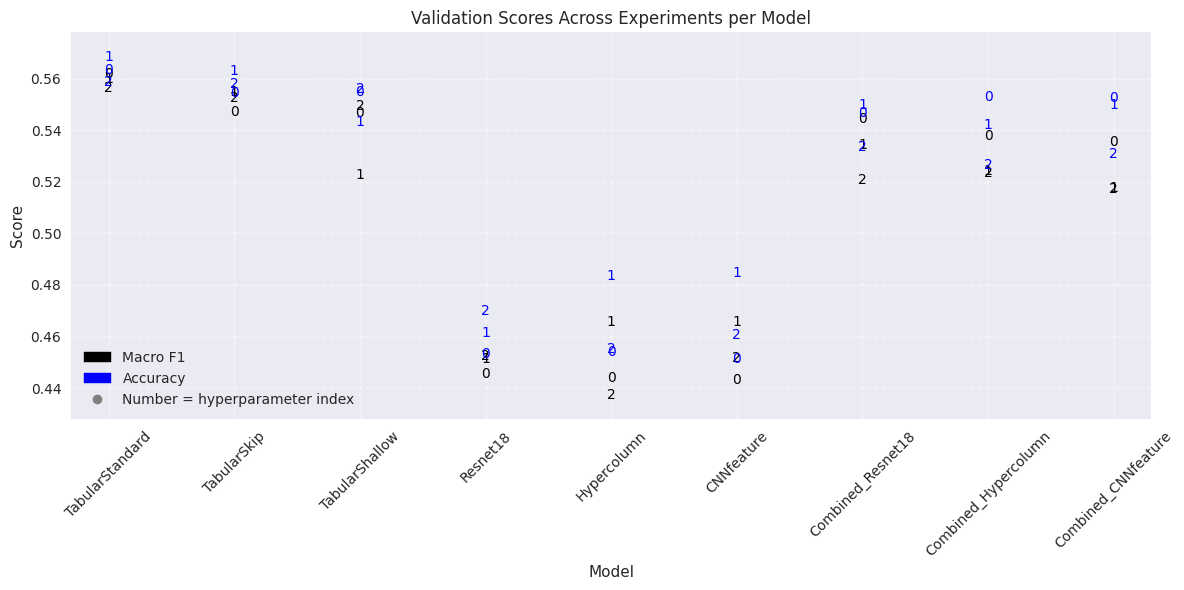

In [37]:
plot_experiments(log_path, save_path="figures/experiments_overview.png")

The table above summarize the performance of all evaluated models across different architectures and hyperparameter configurations. We report validation accuracy and macro-averaged F1 score at the best epoch for each experiment, together with training time statistics.

Among the tabular-only models, TabularStandard achieves the highest validation accuracy (0.566) and macro F1 score (0.559), while also maintaining relatively low training time per epoch. TabularSkip and TabularShallow show slightly lower performance, with the shallow architecture being the fastest to train.

For image-only models, all architectures perform substantially worse than tabular-based approaches, with validation macro F1 scores below 0.47. These models also require significantly longer training times due to the convolutional backbone.

The combined tabular–image models achieve competitive performance compared to tabular-only models but do not surpass them. While Combined_Resnet18 attains a reasonable validation accuracy (0.550), all combined models incur a much higher computational cost, with average epoch times exceeding 35 seconds, largely due to image feature extraction.

These results indicate that tabular features carry the strongest predictive signal for this task, and that incorporating image information increases computational complexity without providing a clear performance gain.

The accompanying figure visualizes validation accuracy and macro F1 across all experiments, with hyperparameter indices indicated for each point. For tabular-only models such as TabularStandard, performance is remarkably consistent across different hyperparameter settings, suggesting that the architecture itself dominates over fine-tuning in driving results. In contrast, some image-based models, particularly the Hypercolumn architecture, show more sensitivity to hyperparameters, with noticeable variation in scores depending on learning rate, dropout, and batch size. Combined models lie in between: their performance varies slightly with hyperparameter choice but remains consistently below the top-performing tabular models.

These observations indicate that careful hyperparameter tuning is more critical for image-based architectures, whereas tabular models are robust to moderate changes in learning rate, dropout, or batch size under the current dataset and training regime. Furthermore, the smaller training sample size available for image-based and combined models likely amplifies this sensitivity, highlighting the importance of both hyperparameter selection and data availability for multimodal approaches.

<a id="83"></a>
### 8.3 Best model choice by architecture (Tabular, Image, Combined)

From the best models per experiment, we further select the single best model for each architecture type : tabular-only, image-only, and combined, based on validation performance (e.g., macro F1 score). This reduces the set to three models in total, one representative per architecture, which will be used for final evaluation and visualization.

In [38]:
model_category = {
    'TabularStandard': 'Tabular',
    'TabularSkip': 'Tabular',
    'TabularShallow': 'Tabular',
    'Resnet18': 'Image',
    'Hypercolumn': 'Image',
    'CNNfeature': 'Image',
    'Combined_Resnet18': 'Combined',
    'Combined_Hypercolumn': 'Combined',
    'Combined_CNNfeature': 'Combined'
}

In [39]:
def get_best_model_for_category(df, category, model_category_mapping):
    filtered = df[df['base_model'].isin([k for k,v in model_category_mapping.items() if v==category])]
    if len(filtered) == 0:
        print(f"No model found for category '{category}'")
        return None
    return filtered.sort_values('val_macro_f1', ascending=False).iloc[0]


best_tabular = get_best_model_for_category(best_experiments, 'Tabular', model_category)
best_image = get_best_model_for_category(best_experiments, 'Image', model_category)
best_combined = get_best_model_for_category(best_experiments, 'Combined', model_category)

# Only keep non-None models
best_models = [m for m in [best_tabular, best_image, best_combined] if m is not None]
print('Best models :')
if best_models:
    display(pd.DataFrame(best_models).T)
else:
    print("No best models found.")

Best models :


0              13                   18
model_name        TabularStandard_0  Hypercolumn_1  Combined_Resnet18_0
dropout_rate                    0.2            0.5                  0.2
learning_rate                0.0001         0.0003               0.0001
batch_size                       16             16                   16
weight_decay                    0.0            0.0                  0.0
weighted_ce                    True           True                 True
n_train_samples               10200           4000                 4000
best_epoch                       82             17                   13
val_acc                    0.566154       0.486154             0.549538
val_macro_f1                0.55911       0.462922             0.541777
total_time_s             273.015464    1094.230362          1069.786303
avg_epoch_time_s           1.365077      36.474345            35.659543
base_model          TabularStandard    Hypercolumn    Combined_Resnet18

Among tabular-only approaches, the TabularStandard model achieved the highest performance, reaching a validation accuracy of 0.566 and a macro F1-score of 0.559 when trained on the full dataset (10,200 samples). For image-only models, the Hypercolumn architecture performed best, though with lower overall performance (macro F1-score 0.463), likely reflecting the higher complexity of visual feature learning. The best multimodal model, Combined_Resnet18, achieved a validation macro F1-score of 0.542, outperforming image-only models but remaining slightly below the tabular baseline. Notably, both image-based and combined models were trained on a reduced subset of 4,000 samples, which likely constrained their performance and may explain why the combined model did not surpass the tabular-only approach despite leveraging complementary image information.

<a id="9"></a>
## 9 Quantitative Results on Test Set

This chapter shows the quantitative results for the best model of each architecture (Tabular, Image, Combined).

<a id="91"></a>
### 9.1 Test Data Preparation:
Two utility functions handle test evaluation:

***get_test_loader***: Prepares a DataLoader adapted to the model type.
   - Tabular models: returns a `TensorDataset` with SWECO features and labels.
   - Image models: loads and transforms RGB images from the PNG folder.
   - Combined models: returns both tabular tensors and image inputs along with labels.

***load_model_from_checkpoint***: Reconstructs the model from a saved checkpoint.
   - Loads hyperparameters, architecture type, and (for combined models) image backbone.
   - Recreates the exact model instance and loads the trained weights.
   - Moves the model to the target device and sets it to evaluation mode.

In [40]:
def get_test_loader(model_type, tabular_tensor=None, image_ids=None, df=None, folder_path=None, transform=None, batch_size=16):
    """
    Returns a DataLoader for the test set, depending on the model type.
    
    - For tabular models, returns a TensorDataset DataLoader.
    - For image-only or combined models, returns a DataLoader with proper batching.
    """
    if model_type in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
        X = tabular_tensor.float()
        y = torch.tensor(df['EUNIS_cls'].values, dtype=torch.long)
        dataset = TensorDataset(X, y)
        return DataLoader(dataset, batch_size=batch_size, shuffle=False)

    elif model_type in ['Resnet18', 'Hypercolumn', 'CNNfeature']:
        dataset = FolderImageDataset(folder_path=folder_path, image_ids=image_ids, labels=df['EUNIS_cls'].values, transform=transform)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        return loader

    elif model_type == 'Combined':
        dataset = CombinedDataset(tabular_tensor=tabular_tensor, df=df, folder_path=folder_path, image_ids=image_ids, transform=transform)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        return loader

    else:
        raise ValueError(f"Unknown model type: {model_type}")

In [41]:
def load_model_from_checkpoint(model_path, input_dim, device='cpu'):
    checkpoint = torch.load(model_path, map_location=device)
    hparams = checkpoint['hyperparameters']
    model_type = checkpoint['model_type']
    image_model = checkpoint.get('image_model', None)

    # Recreate model exactly
    if model_type in ['TabularStandard','TabularSkip','TabularShallow']:
        if model_type == 'TabularStandard':
            model = TabularMLP(input_dim=input_dim, hidden_layers = [512,256,128], dropout=hparams['dropout_rate'], n_classes=17)
        elif model_type == 'TabularSkip':
            model = TabularSkipMLP(input_dim=input_dim, hidden_dim=256, n_blocks=3, dropout=hparams["dropout_rate"], n_classes=17)
        else:
            model = TabularShallowMLP(input_dim=input_dim, hidden_layers = [128,32], dropout=hparams['dropout_rate'], n_classes=17)
    
    elif model_type in ['Resnet18','Hypercolumn','CNNfeature']:
        if model_type == 'Resnet18':
            model = ImageResNet18(n_classes=17, pretrained=True)
        elif model_type == 'Hypercolumn':
            model = ImageHypercolumnResNet(n_classes=17, dropout=hparams['dropout_rate'], pretrained=True)
        else:
            model = ImageCNNFeatureMLP(n_classes=17, pretrained=True, hidden_dim=256, n_blocks=2, dropout=hparams['dropout_rate'])
    
    elif model_type == 'Combined':
        model = CombinedTabularImageModel(tabular_input_dim=input_dim, n_classes=17, tabular_hidden=[256,128],
                                          image_model=image_model, pretrained=True, dropout=hparams['dropout_rate'])
    else:
        raise ValueError(f"Unknown model type in checkpoint: {model_type}")

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, hparams

<a id="92"></a>
### 9.2 Quantitative Results on Test Set

The code below evaluates the best models for each architecture (Tabular, Image, and Combined), on the held-out test set. For each of the three models, it performs the following evualation:

- **Evaluate predictive performance**, including overall accuracy, macro F1 score, per-class F1 scores, and inference time per sample.
- **Plot per-class F1 scores** to visualize class-level performance.
- **Compute permutation-based feature importance** for tabular models, identifying which environmental variables most influence predictions, and visualize group-level importances.

By structuring the analysis this way, we provide a comprehensive yet compact overview of model performance, feature contributions, and potential multimodal gains.


=== Evaluating TabularStandard_0 ===
Accuracy: 0.5831
Macro F1: 0.5805
Inference time per sample: 0.0003 ms


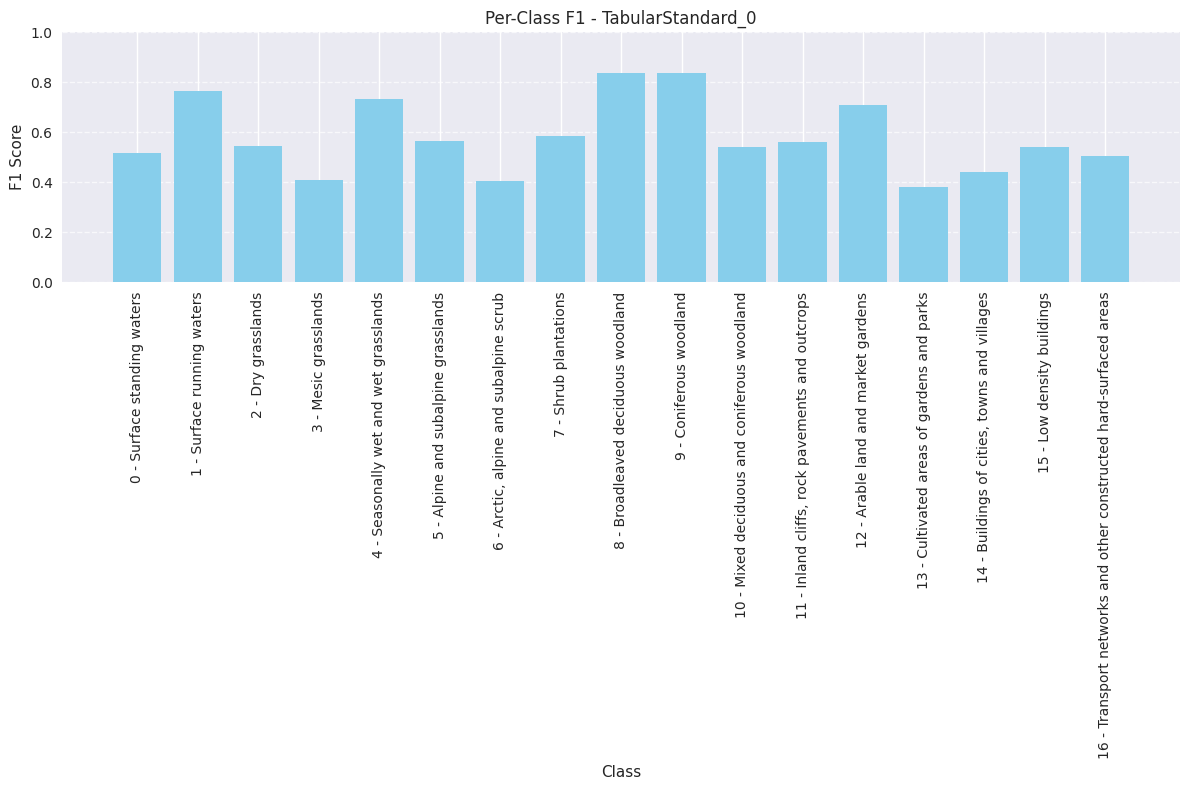

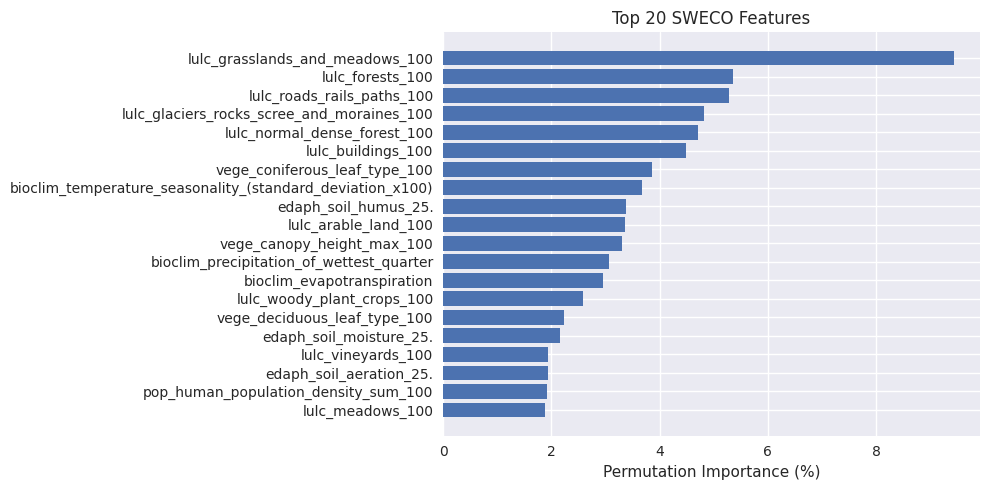

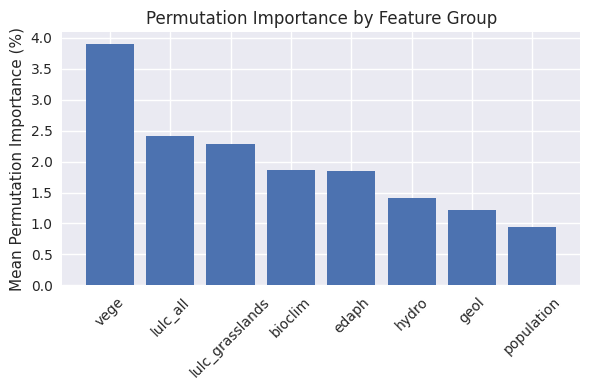


=== Evaluating Hypercolumn_1 ===
Accuracy: 0.4669
Macro F1: 0.4506
Inference time per sample: 0.1703 ms


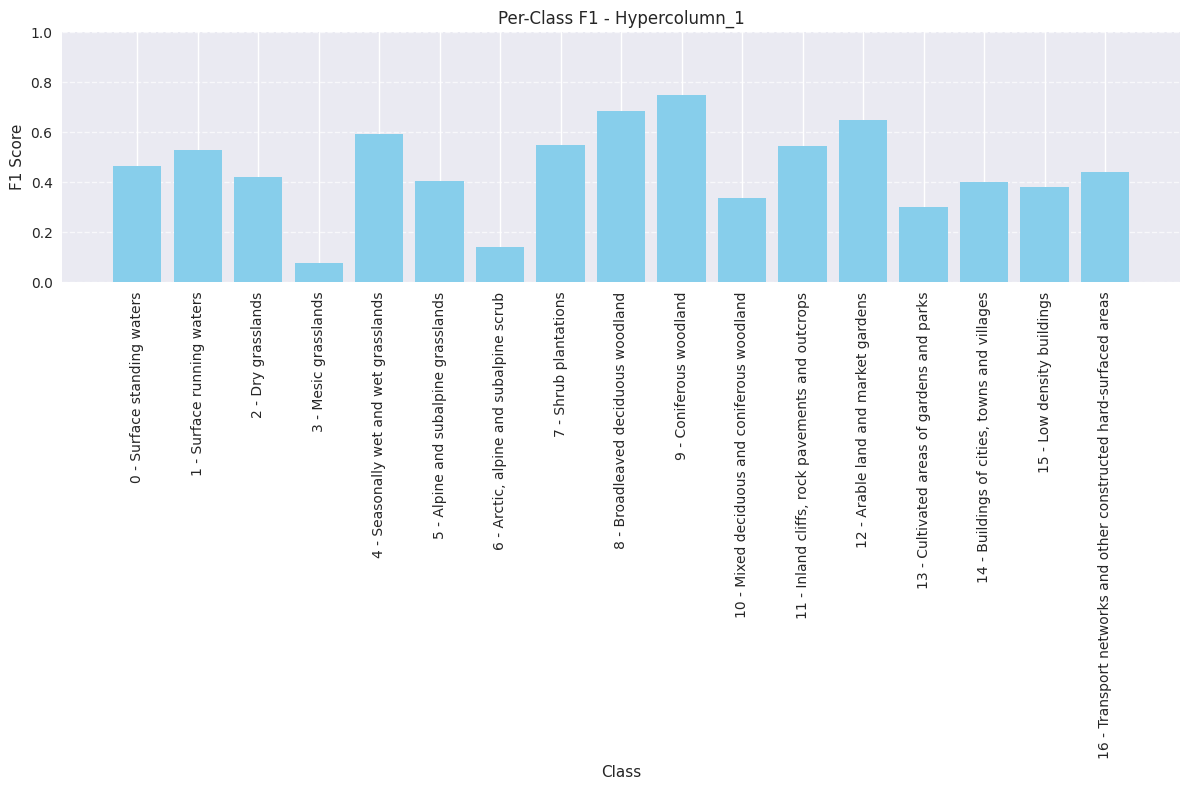

Permutation importance not computed for non-tabular models.

=== Evaluating Combined_Resnet18_0 ===
Accuracy: 0.5667
Macro F1: 0.5602
Inference time per sample: 0.1710 ms


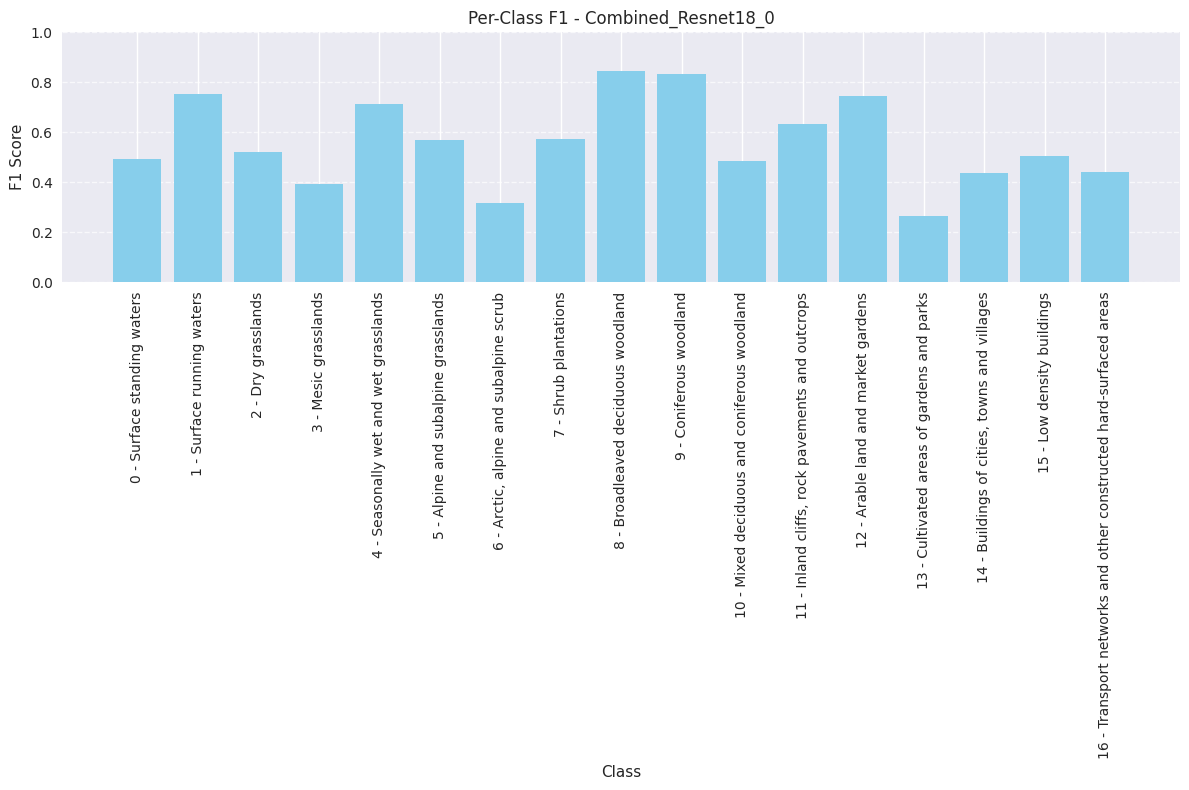

Permutation importance not computed for non-tabular models.


In [42]:
results = {}

for best_model_info in best_models:
    model_name = best_model_info['model_name']
    
    print(f"\n=== Evaluating {model_name} ===")
    
    # Load model and hyperparameters directly from checkpoint
    model_path = f"models/{model_name}.pt"
    model, hparams = load_model_from_checkpoint(model_path, input_dim=Xtest_tensor.shape[1], device=device)
    
    # Determine model type from checkpoint
    model_type = hparams.get('model_type', best_model_info.get('base_model', 'Unknown'))
    if model_type.startswith("Combined"):
        model_type = "Combined"
    
    device = next(model.parameters()).device
    
    # --- Prepare DataLoader depending on model type ---
    if model_type in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
        test_dataset = TensorDataset(Xtest_tensor, ytest_tensor)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        X_input = Xtest_tensor
        y_input = ytest_tensor
    
    elif model_type == 'Combined':
        test_dataset = CombinedDataset(tabular_tensor=Xtest_tensor, df=test_df, folder_path="data/images_png",
                                       image_ids=image_test_ids, transform=eval_image_transform)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        X_input = test_loader  
        y_input = ytest_tensor
    
    else:  # Image-only
        test_dataset = FolderImageDataset(folder_path="data/images_png", image_ids=image_test_ids,
                                          labels=test_df['EUNIS_cls'].values, transform=eval_image_transform)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        X_input = test_loader
        y_input = None  # no permutation importance
    
    # --- Evaluate performance ---
    test_acc, test_f1, test_f1_per_class = evaluate_model_dataloader(model, test_loader, model_type)
     
    # --- Measure inference time ---
    test_inf_time = measure_inference_time(model, X_input, device=device)
    
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Macro F1: {test_f1:.4f}")
    print(f"Inference time per sample: {test_inf_time*1000:.4f} ms")
    
    # Store results
    results[model_name] = {
        "accuracy": test_acc,
        "macro_f1": test_f1,
        "per_class_f1": test_f1_per_class,
        "inference_time_s": test_inf_time
    }
    
    # Plot per-class F1
    plot_path_f1 = f"figures/{model_name}_per_class_f1.png"
    plot_per_class_f1(test_f1_per_class, class_numbers=test_df['EUNIS_cls'].unique(), class_names=test_df['EUNIS_label'].unique(),
                      title=f"Per-Class F1 - {model_name}", save_path=plot_path_f1)
    
    # --- Compute permutation importance only for tabular models ---
    if model_type in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
        feature_importances_pct, group_importances = compute_group_permutation_importance(model=model, X=X_input, y=y_input,
                                                        feature_names=sweco_variables,feature_groups=sweco_variables_dict, n_repeats=5,
                                                        metric=lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), device=device)
        plot_path_perm_group = f"figures/{model_name}_permutation_importance_group.png"
        plot_path_perm_top = f"figures/{model_name}_permutation_importance_top.png"
        plot_permutation_importances(feature_importances_pct, sweco_variables, group_importances,
                                     top_n=20, save_path_group=plot_path_perm_group, save_path_top=plot_path_perm_top)
    else:
        print("Permutation importance not computed for non-tabular models.")

#### Test Set Evaluation and Model Comparison

The three best-performing models identified during validation, TabularStandard, Hypercolumn, and Combined ResNet18, were evaluated on the held-out test set using accuracy, macro F1-score, per-class F1-score, and inference time per sample.

Overall, the TabularStandard model achieved the best performance on the test set, with an accuracy of 0.5831 and a macro F1-score of 0.5805, while also being extremely efficient at inference time (approximately 0.0001 ms per sample). The Combined ResNet18 model followed closely, reaching an accuracy of 0.5667 and a macro F1-score of 0.5602, at the cost of a substantially higher inference time (~0.19 ms per sample). The Hypercolumn image-only model performed noticeably worse, with an accuracy of 0.4669 and a macro F1-score of 0.4506, while exhibiting a similar inference time to the combined model.

Interestingly, both the TabularStandard and Combined ResNet18 models show slightly better results on the test set than on validation, which suggests the absence of overfitting and good generalization to unseen data. For the Hypercolumn model, the metrics are roughly the same or slightly worse on the test set, but there is also no sign of overfitting, indicating that all three models are robust and well-chosen for the task.

These results indicate that, despite integrating image information, the combined model does not outperform the tabular-only approach under the current experimental setup. This is likely influenced by the fact that tabular models were trained on the full training set (10,200 samples), whereas image-based and combined models were limited to 4,000 samples due to data availability and computational constraints. This imbalance may have restricted the potential benefit of multimodal fusion.

#### Permutation Importance Analysis (Tabular Model)

Permutation importance analysis was conducted for the TabularStandard model to identify the most influential feature groups and individual variables.

At the group level, the vegetation-related variables emerged as the most informative, accounting for nearly 4% of the total importance. The second most important group contributed only around 2.3%, indicating a clear dominance of vegetation information in the model’s decision process.

At the individual feature level, lulc_grasslands_and_meadows was by far the most influential variable, contributing over 9% of the total importance. The second-ranked feature showed a much smaller contribution (approximately 5%), with importance values dropping below 2% for the remaining top-20 features. This sharp decline suggests that the model relies strongly on a small subset of highly informative land-cover features rather than a broad combination of variables.

#### Per-Class Performance Analysis

Analysis of per-class F1-scores reveals notable differences in class-wise behavior across models.

The TabularStandard model performs particularly well on classes 1, 4, 8, 9, and 12, achieving high F1-scores, while struggling with classes 3, 6, and 13, for which F1-scores are around 0.4.

The Hypercolumn model exhibits good performance for a small subset of classes, notably 8 and 9, but performs poorly on several others, especially classes 3 and 6, indicating limited generalization when relying solely on image-derived features.

The Combined ResNet18 model largely mirrors the behavior of the tabular model, performing well on classes 1, 4, 8, 9, and 12, but still showing weaknesses for classes 3, 6, and 13.

Overall, all three models tend to struggle on the same classes, suggesting that these habitat types are inherently more difficult to classify regardless of the input modality. This indicates that, in the current experimental setup, adding image information does not substantially improve classification for the more challenging classes. It is worth noting that the validation set was consistent across all experiments, with the exception of classes 1 and 7, which were underrepresented. However, this imbalance did not appear to significantly affect the overall trends observed in model performance.

<a id="10"></a>
## 10. Visual Analysis

This final chapter shows the test set results computed on the overall best model.

<a id="101"></a>
### 10.1 Selection of the best model

The best model is selected from all trained architectures based on the highest **validation macro F1-score**. The corresponding checkpoint is loaded, including model weights and hyperparameters.  

A test DataLoader is then created according to the model type:
- **Tabular models:** use SWECO feature tensors.
- **Image models:** load and transform RGB aerial images.
- **Combined models:** provide both tabular and image inputs.  

Predictions are made batch by batch on the test set, and the true labels and predicted classes are concatenated for downstream evaluation and visualization.


In [44]:
best_overall = max(best_models, key=lambda m: m['val_macro_f1'])
print(f'Best model')
display(best_overall.to_frame())

checkpoint = torch.load(model_path, map_location=device)

model_name = best_overall['model_name']
model_path = f"models/{model_name}.pt"

# Load model and hyperparameters from checkpoint
model, hparams_loaded = load_model_from_checkpoint(model_path, input_dim=Xtest_tensor.shape[1], device=device)
model_type = checkpoint['model_type']
model.eval()

# --- Prepare test DataLoader instead of stacking all tensors ---
test_loader = get_test_loader(model_type=model_type, tabular_tensor=Xtest_tensor, image_ids=image_test_ids, df=test_df,
                              folder_path="data/images_png", transform=eval_image_transform, batch_size=16)

all_preds = []
all_true = []

# --- Make predictions batch by batch ---
with torch.no_grad():
    for batch in test_loader:
        if model_type in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
            X, y = batch
            X = X.to(device)
            outputs = model(X)

        elif model_type in ['Resnet18', 'Hypercolumn', 'CNNfeature']:
            X, y = batch
            X = X.to(device)
            outputs = model(X)

        elif model_type == 'Combined':
            X_tab, X_img, y = batch
            X_tab, X_img = X_tab.to(device), X_img.to(device)
            outputs = model(X_tab, X_img)

        else:
            raise ValueError(f"Unknown model type: {model_type}")

        # Store predictions
        all_preds.append(outputs.argmax(1).cpu())
        all_true.append(y.cpu())

# Concatenate all batch predictions
test_pred_labels = torch.cat(all_preds)
y_test_labels = torch.cat(all_true)

Best model


0
model_name        TabularStandard_0
dropout_rate                    0.2
learning_rate                0.0001
batch_size                       16
weight_decay                    0.0
weighted_ce                    True
n_train_samples               10200
best_epoch                       82
val_acc                    0.566154
val_macro_f1                0.55911
total_time_s             273.015464
avg_epoch_time_s           1.365077
base_model          TabularStandard

<a id="102"></a>
### 10.2 Confusion Matrix

- Visualization of the best-performing model’s predictions.  
- Frequent misclassifications are highlighted for interpretability.  
- Cells with zero counts (or proportions) are omitted for clarity.

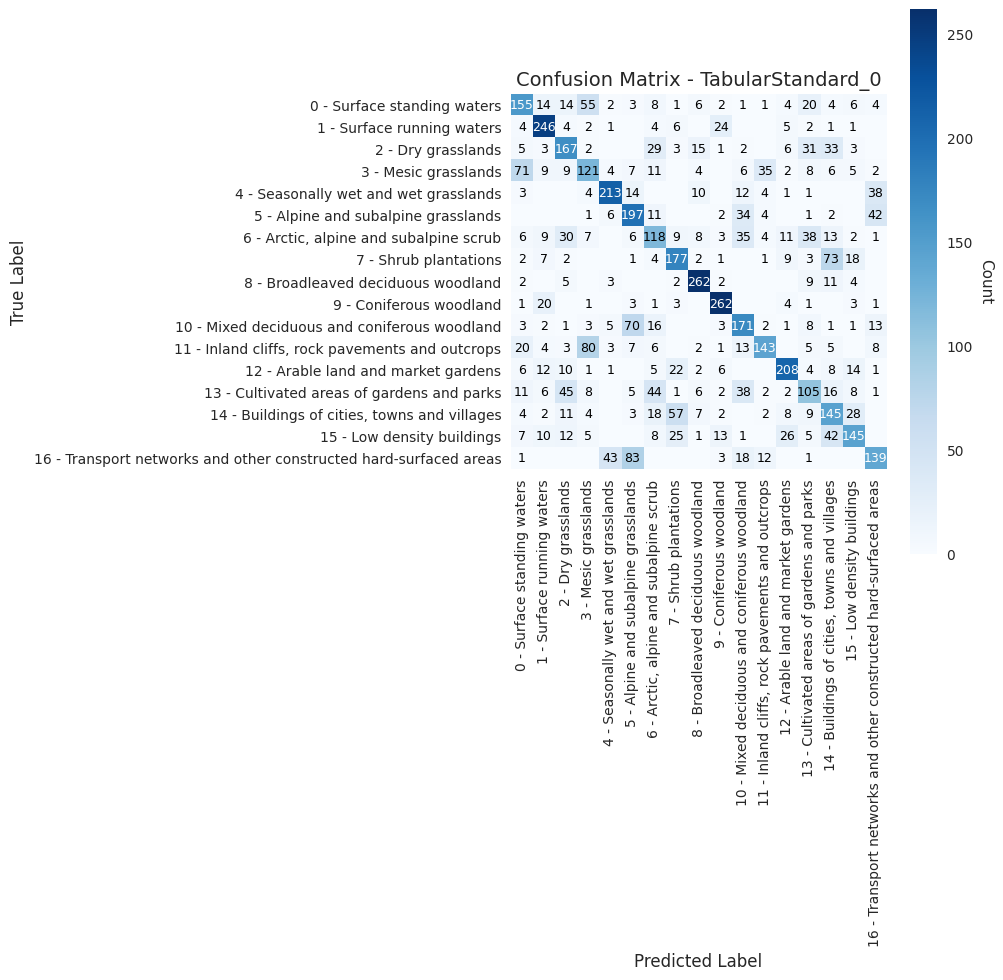

In [45]:
plot_path_confusion = f"figures/{model_name}_confusion.png"
plot_confusion_matrix(y_true=y_test_labels, y_pred=test_pred_labels, class_numbers=test_df['EUNIS_cls'].unique(),
                      class_names=test_df['EUNIS_label'].unique(), title=f"Confusion Matrix - {model_name}",
                      save_path=plot_path_confusion, normalize=False)

The confusion matrix for the TabularStandard model on the test set confirms the patterns seen in the per-class F1 analysis. Classes 1, 4, 8, 9, and 12 are well-classified, with only occasional misclassifications. Some errors are ecologically understandable: for example, class 3 (mesic grasslands) is often classified as class 0 (surface standing waters), and class 10 (mixed deciduous and coniferous woodland) as class 6 (alpine and subalpine grasslands), which reflects the similarity between these habitats. However, the misclassification of class 11 (inland cliffs, rock pavements, and outcrops) as class 3 (mesic grasslands) is somewhat surprising, as these habitats are less similar. Overall, the confusion matrix shows that most misclassifications occur between ecologically related classes, providing insight into where the model struggles and why.

<a id="103"></a>
### 10.3 Spatial Visualization

- Map predicted ecosystem classes over Switzerland.
- Highlight prediction correctness per location.  
- *create_test_geodf* converts the test dataset and predictions into a GeoDataFrame with coordinates, predicted class, and correctness.
- *plot_predictions_map* visualizes the GeoDataFrame on a basemap using color-coded predicted classes or correctness.


In [46]:
def create_test_geodf(test_df, y_true, y_pred, x_col='x', y_col='y', crs=2056):
    """
    Convert test dataframe with predictions to a GeoDataFrame.
    
    Args:
        test_df: pandas DataFrame with coordinates and original data
        y_true: true labels (numpy array or torch tensor)
        y_pred: predicted labels (numpy array or torch tensor)
        x_col, y_col: column names for coordinates
        crs: initial CRS of the coordinates
    Returns:
        gdf: GeoDataFrame with predictions and correctness
    """
    # Ensure numpy arrays
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    correct = y_true == y_pred
    gdf = test_df.copy()
    gdf['pred_class'] = y_pred
    gdf['correct'] = correct
    gdf['geometry'] = [Point(xy) for xy in zip(gdf[x_col], gdf[y_col])]
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs=f"EPSG:{crs}")
    gdf = gdf.to_crs(epsg=3857)
    return gdf

def plot_predictions_map(gdf, column='pred_class', cmap='tab20', title="Predicted Classes", save_path = None):
    """
    Plot predicted classes or correctness on a basemap.
    
    Args:
        gdf: GeoDataFrame with 'geometry' and the column to color
        column: which column to plot ('pred_class' or 'correct')
        cmap: colormap
        title: plot title
    """
    fig, ax = plt.subplots(figsize=(12,8))
    gdf.plot(ax=ax, column=column, cmap=cmap, markersize=15, legend=True)
    ax.set_xlim(gdf.total_bounds[0]-10000, gdf.total_bounds[2]+10000)
    ax.set_ylim(gdf.total_bounds[1]-15000, gdf.total_bounds[3]+15000)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    plt.title(title)
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

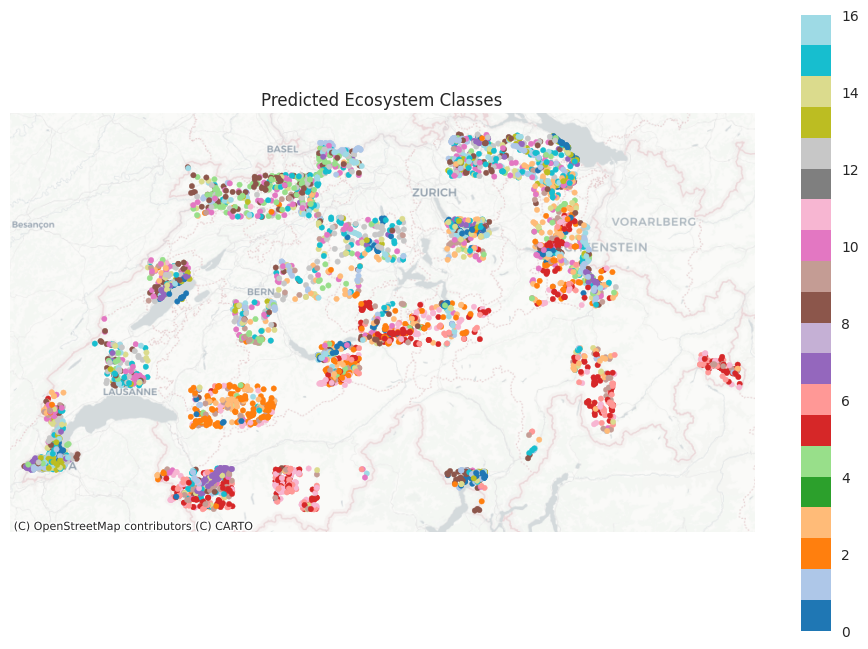

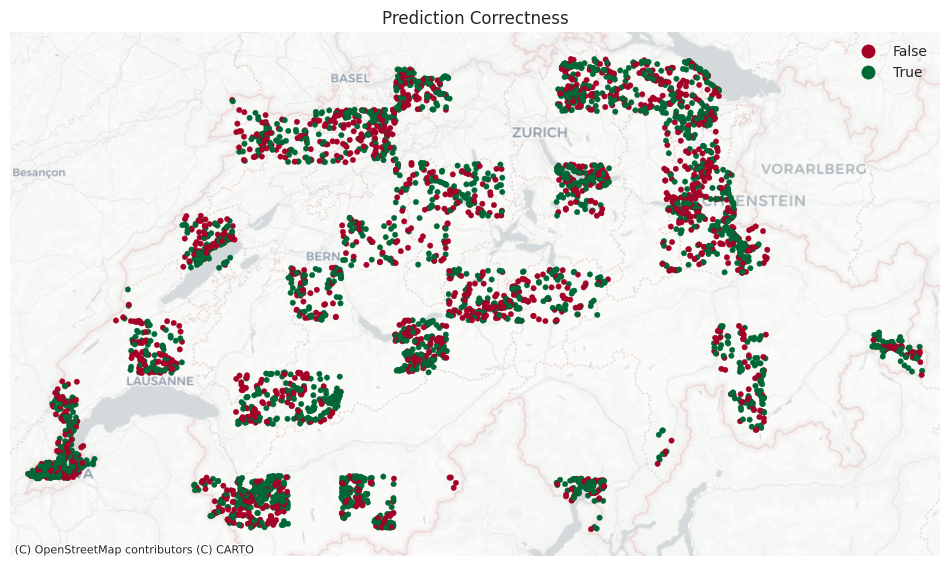

In [47]:
# Spatial visualization (works if the model has coordinates)
gdf_test = create_test_geodf(test_df, y_true=y_test_labels, y_pred=test_pred_labels)
plot_predictions_map(gdf_test, column='pred_class', cmap='tab20', title="Predicted Ecosystem Classes", save_path=f"figures/{model_name}_pred_class.png")
plot_predictions_map(gdf_test, column='correct', cmap='RdYlGn', title="Prediction Correctness", save_path=f"figures/{model_name}_pred_correct.png")

#### Spatial analysis of TabularStandard predictions

Spatial visualization of the TabularStandard model predictions provides additional insight into model behavior. The map of predicted classes shows that some classes tend to co-occur in the same regions, which aligns with ecological expectations and reflects habitat similarity. While the spatial distribution of classes is generally coherent, it is challenging to interpret fine-scale patterns purely from the predicted class map.

The map of prediction correctness (correct vs. incorrect predictions) is particularly informative. Errors appear scattered across the study area, without noticeable spatial clustering. This uniform distribution of misclassifications indicates that the model does not exhibit location-specific biases, supporting the conclusion that the train-validation-test split was effective. It also reinforces that misclassifications are likely driven by intrinsic similarities between classes (e.g., certain grasslands vs. wetlands) rather than spatial artifacts, suggesting that the model generalizes robustly across space.

<a id="11"></a>
## 11. Final Remarks

This notebook completes the full analysis workflow, from data preparation and model training to evaluation and visualization.
All steps are reproducible given the provided code, datasets, and parameters.

Evaluation of the top-performing models, TabularStandard, Hypercolumn, and Combined ResNet18, on the held-out test set confirms and extends the trends observed during validation. The TabularStandard model emerged as the most effective overall, achieving the highest predictive accuracy and consistently strong performance across several key habitat classes. The Combined ResNet18 model, which incorporates both tabular and image data, performed slightly below the tabular-only model, while the image-only Hypercolumn model achieved lower performance overall. This suggests that, under the current setup, tabular descriptors capture the majority of the informative signal, and the benefit of multimodal fusion is limited by the smaller training sample available for image-based models.

Analysis of per-class F1-scores reveals that all three models tend to struggle with the same challenging classes, indicating that these misclassifications are driven more by intrinsic similarities between habitat types than by model deficiencies. The confusion matrix for TabularStandard shows that most classes are well-predicted, while certain classes, such as mesic grasslands, mixed woodlands, and inland cliffs, are occasionally misclassified as ecologically similar classes. Some of these mismatches are expected due to habitat similarity, while others, such as inland cliffs being classified as mesic grasslands, are more surprising and highlight areas for further investigation.

Spatial visualization further supports the robustness of the models. The predicted class distribution is generally coherent with ecological expectations, and importantly, the map of prediction correctness shows that errors are distributed uniformly across space. This indicates that the models do not suffer from location-specific biases and that the train-validation-test split was effective, promoting strong generalization.

Overall, the combination of quantitative metrics, per-class and confusion matrix analyses, and spatial evaluation demonstrates that the models are well-chosen and robust. They capture key ecological patterns, generalize reliably across the study area, and provide a foundation for interpretable habitat predictions. These results support the conclusions drawn in the accompanying report and provide guidance for future improvements, particularly for the more challenging classes and potential expansion of image-based training data.

>**Note**: the random seed ensures reproducibility only if the entire workflow is executed in the same order. Deviating from this order or changing data processing steps may lead to different results.